In [ ]:
# CELL 1: Setup
print("Installing libraries...")
!pip install gnss_lib_py tqdm numpy matplotlib torch -qq

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gnss_lib_py as glp
import gnss_lib_py.utils.constants as consts
from tqdm.auto import tqdm
import subprocess
import warnings
from google.colab import drive
from google.colab import files

warnings.filterwarnings("ignore")

print("Mounting Google Drive...")
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/AA272/GPS_Project"
DATA_OUTPUT_DIR = os.path.join(PROJECT_ROOT, "training_tensors_NESW")
os.makedirs(DATA_OUTPUT_DIR, exist_ok=True)
print(f"Project Directories ready. Data will be saved to: {DATA_OUTPUT_DIR}")

Installing libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 6.2 MB/s eta 0:00:00
Mounting Google Drive...
Mounted at /content/drive
Project Directories ready. Data will be saved to: /content/drive/MyDrive/AA272/GPS

In [ ]:
# Upload GFZRNX
GFZRNX_PATH = "gfzrnx_linux_64" # rename for simplicity

if not os.path.exists(GFZRNX_PATH):
    print("Please upload the 'gfzrnx..._linux_x86_64' executable file.")
    uploaded = files.upload()
    if not uploaded:
        print("Upload cancelled.")
    else:
        # rename the uploaded file to a simple name and make executable
        original_name = next(iter(uploaded))
        os.rename(original_name, GFZRNX_PATH)
        os.chmod(GFZRNX_PATH, 0o755)
        print(f"GFZRNX tool prepared as '{GFZRNX_PATH}'")
else:
    print(f"GFZRNX tool found at '{GFZRNX_PATH}'")

Please upload the 'gfzrnx..._linux_x86_64' executable file.


Saving gfzrnx_2.2.0_lx64 to gfzrnx_2.2.0_lx64
GFZRNX tool prepared as 'gfzrnx_linux_64'


In [ ]:

def newton_raphson_for_eccentric_anomaly(mean_anomaly, eccentricity, tol=1e-10, max_iter=10):
    ecc_anomaly = mean_anomaly
    for _ in range(max_iter):
        correction = -(ecc_anomaly - eccentricity * np.sin(ecc_anomaly) - mean_anomaly) / (1 - eccentricity * np.cos(ecc_anomaly))
        ecc_anomaly += correction
        if np.all(np.abs(correction) < tol):
            break
    return ecc_anomaly

def orbit_params_to_sv_states(gps_millis, ephem_orbit_params):
    gps_week, gps_tow = glp.gps_millis_to_tow(gps_millis)
    sv_posvel = glp.NavData()
    sv_posvel["gnss_id"] = ephem_orbit_params["gnss_id"]
    sv_posvel["sv_id"] = ephem_orbit_params["sv_id"]
    sv_posvel["gps_millis"] = gps_millis

    t_offset_clock = gps_tow - ephem_orbit_params["t_oc"]
    t_offset_clock[t_offset_clock > 302400] -= 604800
    t_offset_clock[t_offset_clock < -302400] += 604800

    gpsweek_diff = (np.mod(gps_week, 1024) - np.mod(ephem_orbit_params["gps_week"], 1024)) * consts.WEEKSEC
    delta_t = gps_tow - ephem_orbit_params["t_oe"] + gpsweek_diff

    sqrt_sma = ephem_orbit_params["sqrtA"]; sma = sqrt_sma**2
    ecc = ephem_orbit_params["e"]
    sqrt_mu_a = np.sqrt(consts.MU_EARTH) * sqrt_sma**-3
    mean_anom = ephem_orbit_params["M_0"] + (sqrt_mu_a + ephem_orbit_params["deltaN"]) * delta_t
    ecc_anom = newton_raphson_for_eccentric_anomaly(mean_anom, ecc)

    F_REL = -4.442807633e-10
    corr_relativistic_s = F_REL * ecc * sqrt_sma * np.sin(ecc_anom)
    clock_bias_s = (ephem_orbit_params["SVclockBias"] + ephem_orbit_params["SVclockDrift"] * t_offset_clock + ephem_orbit_params["SVclockDriftRate"] * t_offset_clock**2 + corr_relativistic_s)

    cos_e = np.cos(ecc_anom); sin_e = np.sin(ecc_anom)
    e_cos_e = 1 - ecc * cos_e
    sin_nu = np.sqrt(1 - ecc**2) * (sin_e / e_cos_e)
    cos_nu = (cos_e - ecc) / e_cos_e
    nu_rad = np.arctan2(sin_nu, cos_nu)

    phi_0 = nu_rad + ephem_orbit_params["omega"]
    cos_2phi = np.cos(2.0 * phi_0); sin_2phi = np.sin(2.0 * phi_0)
    phi_corr = ephem_orbit_params["C_uc"] * cos_2phi + ephem_orbit_params["C_us"] * sin_2phi
    r_corr = ephem_orbit_params["C_rc"] * cos_2phi + ephem_orbit_params["C_rs"] * sin_2phi
    i_corr = ephem_orbit_params["C_ic"] * cos_2phi + ephem_orbit_params["C_is"] * sin_2phi

    phi = phi_0 + phi_corr
    orb_radius = sma * e_cos_e + r_corr
    incl = ephem_orbit_params["i_0"] + i_corr + ephem_orbit_params["IDOT"] * delta_t

    x_plane = orb_radius * np.cos(phi); y_plane = orb_radius * np.sin(phi)
    omega = (ephem_orbit_params["Omega_0"] + (ephem_orbit_params["OmegaDot"] - consts.OMEGA_E_DOT) * delta_t - consts.OMEGA_E_DOT * ephem_orbit_params["t_oe"])
    cos_omega = np.cos(omega); sin_omega = np.sin(omega); cos_i = np.cos(incl); sin_i = np.sin(incl)

    sv_posvel["x_sv_m"] = x_plane * cos_omega - y_plane * cos_i * sin_omega
    sv_posvel["y_sv_m"] = x_plane * sin_omega + y_plane * cos_i * cos_omega
    sv_posvel["z_sv_m"] = y_plane * sin_i
    sv_posvel["b_sv_m"] = clock_bias_s * consts.C
    return sv_posvel

def compute_az_el(states_data, rx_pos_ecef):
    sv_pos_ecef = states_data[['x_sv_m', 'y_sv_m', 'z_sv_m']]
    rx_lat_rad, rx_lon_rad, _ = np.deg2rad(glp.ecef_to_geodetic(rx_pos_ecef)[0])
    sin_lat, cos_lat = np.sin(rx_lat_rad), np.cos(rx_lat_rad)
    sin_lon, cos_lon = np.sin(rx_lon_rad), np.cos(rx_lon_rad)
    R = np.array([[-sin_lon, cos_lon, 0], [-sin_lat * cos_lon, -sin_lat * sin_lon, cos_lat], [ cos_lat * cos_lon, cos_lat * sin_lon, sin_lat]])
    los_ecef = sv_pos_ecef - rx_pos_ecef.reshape(3, 1)
    los_enu = np.einsum('ij,jk->ik', R, los_ecef).T
    east, north, up = los_enu[:, 0], los_enu[:, 1], los_enu[:, 2]
    states_data['el_sv_deg'] = np.rad2deg(np.arctan2(up, np.sqrt(east**2 + north**2)))
    az = np.rad2deg(np.arctan2(east, north))
    az[az < 0] += 360
    states_data['az_sv_deg'] = az
    return states_data

def get_closest_ephem(gps_millis, nav_data):
    rinex_gps = nav_data.where("gnss_id", "gps", "eq")
    time_cropped = rinex_gps.where("gps_millis", gps_millis, "lesser")
    if len(time_cropped) == 0: return glp.NavData()
    best_params = time_cropped.pandas_df().sort_values("gps_millis").groupby("gnss_sv_id").last()
    return glp.NavData(pandas_df=best_params.reset_index())

In [ ]:
# CNN Model Definition
import torch
import torch.nn as nn
import torch.nn.functional as F

class GPSCompassCNN(nn.Module):
    def __init__(self, height, width, num_classes=4):
        super(GPSCompassCNN, self).__init__()

        # Input shape: (Batch, 1, 6, 18)

        # Conv 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Conv 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Pooling (We only pool once because input is small)
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate size after pooling
        # 6x18 -> Pool -> 3x9
        self.flat_size = 32 * (height // 2) * (width // 2)

        # FC Layers
        self.fc1 = nn.Linear(self.flat_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (Batch, 1, 6, 18)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = x.view(x.size(0), -1) # Flatten

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [ ]:
# Processor + Diagnostic Plots

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gnss_lib_py as glp
import os
import glob
from tqdm.auto import tqdm

def process_rotating_log(rinex_4_filename, is_baseline=False, metric="pr"):
    """
    metric: "pr" (Pseudorange/Timing) or "cn0" (Signal Strength/Power)
    """

    # get output directory
    if is_baseline:
        base_dir = "training_tensors_EMPTY"
    else:
        base_dir = "training_tensors_ROTATING"

    out_dir = os.path.join(PROJECT_ROOT, f"{base_dir}_{metric.upper()}")
    if not os.path.exists(out_dir): os.makedirs(out_dir)

    print(f"\nPROCESSING: {rinex_4_filename} -> {out_dir} (Mode: {metric.upper()})")

    # convert to RINEX 3
    base_name = os.path.splitext(rinex_4_filename)[0]
    rinex_3_filename = f"{base_name}.rnx"
    if not os.path.exists(rinex_3_filename):
        subprocess.run(['./gfzrnx_linux_64', '-finp', rinex_4_filename, '-fout', rinex_3_filename, '-vo', '3.03'], check=True)

    # load Data
    obs_data = glp.RinexObs(rinex_3_filename).where("gnss_id", "gps", "eq")
    nav_file = glp.load_ephemeris(file_type="rinex_nav", gps_millis=obs_data["gps_millis", 0])
    nav_data = glp.RinexNav(nav_file)

    # compute states & extract metrics
    unique_times = np.unique(obs_data['gps_millis'])
    all_dfs = []

    for t in tqdm(unique_times, desc="Extracting Data", leave=False):
        obs_t = obs_data.where('gps_millis', t)
        ephem = get_closest_ephem(t, nav_data)
        common = np.intersect1d(obs_t['sv_id'], ephem['sv_id'])
        if len(common) == 0: continue

        ephem = ephem.where('sv_id', common); obs_t = obs_t.where('sv_id', common)
        states = orbit_params_to_sv_states(t, ephem)

        obs_map = {sv: i for i, sv in enumerate(obs_t['sv_id'])}
        raw_pr = np.zeros(len(states)); raw_cn0 = np.zeros(len(states))

        for i, sv in enumerate(states['sv_id']):
            idx = obs_map[sv]
            raw_pr[i] = obs_t['raw_pr_m', idx]
            raw_cn0[i] = obs_t['cn0_dbhz', idx]

        states['raw_pr_m'] = raw_pr
        states['cn0_dbhz'] = raw_cn0
        all_dfs.append(states.pandas_df())

    full_df = pd.concat(all_dfs).reset_index(drop=True)

    # get angles (WLS)
    rx_pos = np.array([0.0, 0.0, 0.0])
    try:
        nav_obj = glp.NavData(pandas_df=full_df.iloc[:50].copy())
        nav_obj['corr_pr_m'] = nav_obj['raw_pr_m'] - nav_obj['b_sv_m']
        wls = glp.solve_wls(nav_obj)
        if len(wls) > 0:
            if isinstance(wls, pd.DataFrame): rx_pos = wls.iloc[0][['x_rx_wls_m','y_rx_wls_m','z_rx_wls_m']].values.astype(float)
            else: rx_pos = np.array([wls['x_rx_wls_m'][0], wls['y_rx_wls_m'][0], wls['z_rx_wls_m'][0]])
    except: pass

    full_nav = glp.NavData(pandas_df=full_df)
    full_nav = compute_az_el(full_nav, rx_pos)
    df_final = full_nav.pandas_df()

    # Only plot if we have data
    if not df_final.empty:
        # Find best satellite
        target_sv = df_final['sv_id'].value_counts().idxmax()
        track = df_final[df_final['sv_id'] == target_sv].sort_values('gps_millis')
        t_full = (track['gps_millis'].values - track['gps_millis'].values[0]) / 1000.0

        # get a 20s Window -- this is just to visualize the zoom in
        start_idx = int(len(track) * 0.4) # Pick a spot 40% in
        t_start = t_full[start_idx]
        mask_win = (t_full >= t_start) & (t_full < t_start + 20)
        t_win = t_full[mask_win]

        if len(t_win) > 5:
            pr_win = track.loc[mask_win, 'raw_pr_m'].values
            cn0_win = track.loc[mask_win, 'cn0_dbhz'].values

            fig, axes = plt.subplots(2, 2, figsize=(16, 10))
            fig.suptitle(f"Detrending Diagnostics: {base_name} (Mode: {metric.upper()})", fontsize=14, fontweight='bold')

            # Pseudorange
            # PR All Satellites
            ax = axes[0,0]
            for sv in df_final['sv_id'].unique():
                st = df_final[df_final['sv_id']==sv].sort_values('gps_millis')
                ts = (st['gps_millis'].values - st['gps_millis'].values[0])/1000.0
                # Detrend linear just for viz
                if len(ts) > 1:
                    p = np.polyfit(ts, st['raw_pr_m'], 1)
                    ax.plot(ts, st['raw_pr_m'] - np.polyval(p, ts), alpha=0.4, lw=1)
            ax.set_title("Overall Pseudorange Noise (All SVs)"); ax.set_ylabel("Residuals (m)")

            # PR Zoom + Polyfit
            ax = axes[0,1]
            coeffs = np.polyfit(t_win, pr_win, 2)
            curve = np.polyval(coeffs, t_win)
            offset = np.mean(pr_win)
            ax.scatter(t_win, pr_win - offset, color='blue', alpha=0.5, label='Raw')
            ax.plot(t_win, curve - offset, 'r--', lw=2, label='PolyFit')
            ax.set_title(f"20s Zoom: Pseudorange Polyfit (SV: {target_sv})")
            ax.legend(); ax.grid(True, alpha=0.3)

            # C/N0
            # C/N0 All Satellites
            ax = axes[1,0]
            for sv in df_final['sv_id'].unique():
                st = df_final[df_final['sv_id']==sv].sort_values('gps_millis')
                ts = (st['gps_millis'].values - st['gps_millis'].values[0])/1000.0
                ax.plot(ts, st['cn0_dbhz'], alpha=0.4, lw=1)
            ax.set_title("Overall Signal Strength (All SVs)"); ax.set_ylabel("dB-Hz")

            # C/N0 Zoom + Polyfit
            ax = axes[1,1]
            coeffs = np.polyfit(t_win, cn0_win, 2)
            curve = np.polyval(coeffs, t_win)
            ax.scatter(t_win, cn0_win, color='green', alpha=0.5, label='Raw')
            ax.plot(t_win, curve, 'r--', lw=2, label='PolyFit')
            ax.set_title(f"20s Zoom: C/N0 Polyfit (SV: {target_sv})")
            ax.legend(); ax.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    # Slicing and Detrending (Generate Tensors)
    TIME_WINDOW_MS = 20000
    time_bins = np.arange(df_final['gps_millis'].min(), df_final['gps_millis'].max() + TIME_WINDOW_MS, TIME_WINDOW_MS)
    df_final['time_bin'] = pd.cut(df_final['gps_millis'], bins=time_bins, right=False)

    az_bins = np.arange(0, 361, 20); el_bins = np.arange(0, 91, 15)
    count = 0
    labels_map = {0: "North", 1: "East", 2: "South", 3: "West"}

    for i, (_, win_df) in enumerate(df_final.groupby('time_bin')):
        if len(win_df) < 50: continue

        if is_baseline:
            current_label_id = 99; current_label_name = "Empty"
        else:
            current_label_id = i % 4
            current_label_name = labels_map[current_label_id]

        win_df = win_df.copy(); win_df['poly_residual'] = np.nan
        for sv in win_df['sv_id'].unique():
            sv_track = win_df[win_df['sv_id'] == sv]
            if len(sv_track) < 5: continue

            t = sv_track['gps_millis'].values.astype(float); t = t - t[0]

            # SWITCH metric here
            if metric == "pr": vals = sv_track['raw_pr_m'].values
            else: vals = sv_track['cn0_dbhz'].values

            try:
                coeffs = np.polyfit(t, vals, 2)
                win_df.loc[sv_track.index, 'poly_residual'] = vals - np.polyval(coeffs, t)
            except: continue

        win_df['az_bin'] = pd.cut(win_df['az_sv_deg'], bins=az_bins, labels=False)
        win_df['el_bin'] = pd.cut(win_df['el_sv_deg'], bins=el_bins, labels=False)

        grid = win_df.groupby(['el_bin', 'az_bin'])['poly_residual'].std().unstack()
        grid = grid.reindex(index=np.arange(len(el_bins)-1), columns=np.arange(len(az_bins)-1))

        clip_max = 10.0 if metric == "pr" else 25.0
        grid_np = np.clip(grid.fillna(0.0).values, 0, clip_max)

        safe_base = base_name.replace(".", "_")
        filename = f"{safe_base}_{current_label_id}_{current_label_name}_{i:05d}.npy"
        np.save(os.path.join(out_dir, filename), grid_np)
        count += 1

    print(f"  -> Generated {count} samples.")

In [ ]:
# Setup New Directories
import shutil
import os

ROTATING_DIR = os.path.join(PROJECT_ROOT, "training_tensors_ROTATING")
EMPTY_DIR = os.path.join(PROJECT_ROOT, "training_tensors_EMPTY_NEW")

# clean up old data to ensure purity
for d in [ROTATING_DIR, EMPTY_DIR]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

print(f"Created clean directories:\n  {ROTATING_DIR}\n  {EMPTY_DIR}")

Created clean directories:
  /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING
  /content/drive/MyDrive/AA272/GPS_Project/training_tensors_EMPTY_NEW


In [ ]:
import shutil
import os

DIR_PR = "/content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_PR"
DIR_CN0 = "/content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_CN0"

# nuke everything to clean folders
for d in [DIR_PR, DIR_CN0]:
    if os.path.exists(d):
        print(f"Deleting duplicate data in: {d}")
        shutil.rmtree(d)
    os.makedirs(d)

print("\nFolders are clean. Now re-run the 'Cell 3: Execution (Dual Mode)' cell.")

Deleting duplicate data in: /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_PR
Deleting duplicate data in: /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_CN0

Folders are clean. Now re-run the 'Cell 3: Execution (Dual Mode)' cell.


STEP 1: Upload the 4 'ACTIVE' (Rotating) logs...


Saving gnss_log_2024_11_28_14_49_49.24o to gnss_log_2024_11_28_14_49_49.24o
Saving gnss_log_2024_11_28_15_01_08.24o to gnss_log_2024_11_28_15_01_08.24o
Saving gnss_log_2024_11_28_15_11_20.24o to gnss_log_2024_11_28_15_11_20.24o
Saving gnss_log_2024_11_28_15_21_39.24o to gnss_log_2024_11_28_15_21_39.24o

STEP 2: Upload the 1 'BASELINE' (Empty) log...


Saving gnss_log_2024_11_28_15_32_09.24o to gnss_log_2024_11_28_15_32_09.24o

PROCESSING: gnss_log_2024_11_28_14_49_49.24o -> /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_PR (Mode: PR)


Extracting Data:   0%|          | 0/600 [00:00<?, ?it/s]

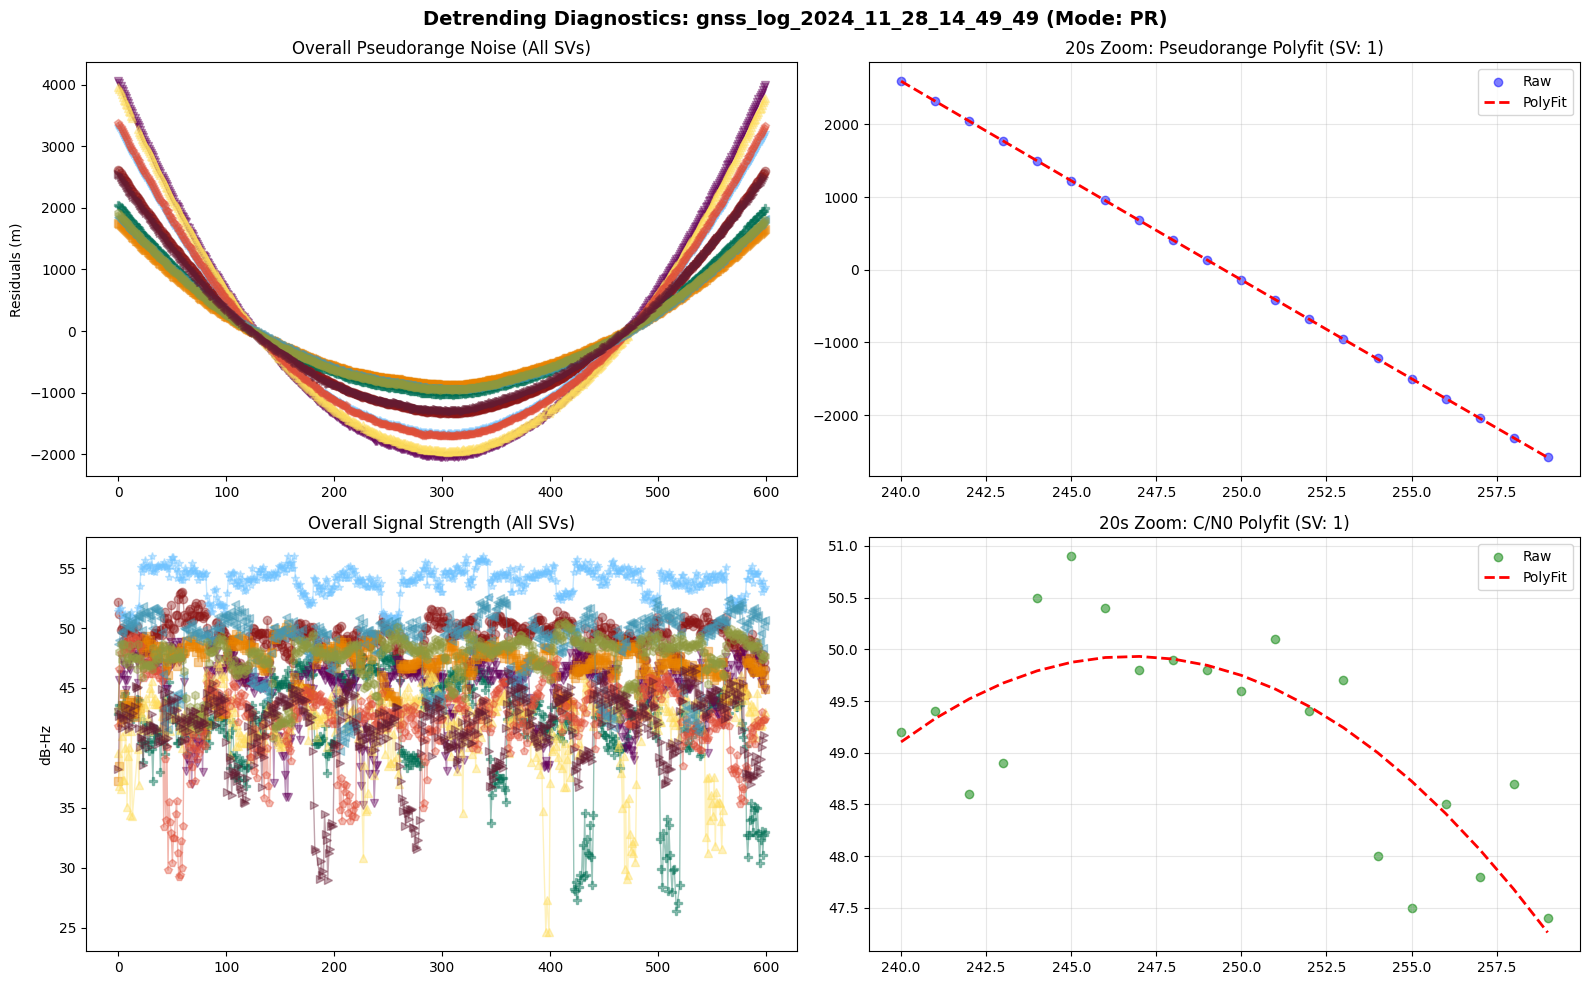

  -> Generated 30 samples.

PROCESSING: gnss_log_2024_11_28_14_49_49.24o -> /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_CN0 (Mode: CN0)


Extracting Data:   0%|          | 0/600 [00:00<?, ?it/s]

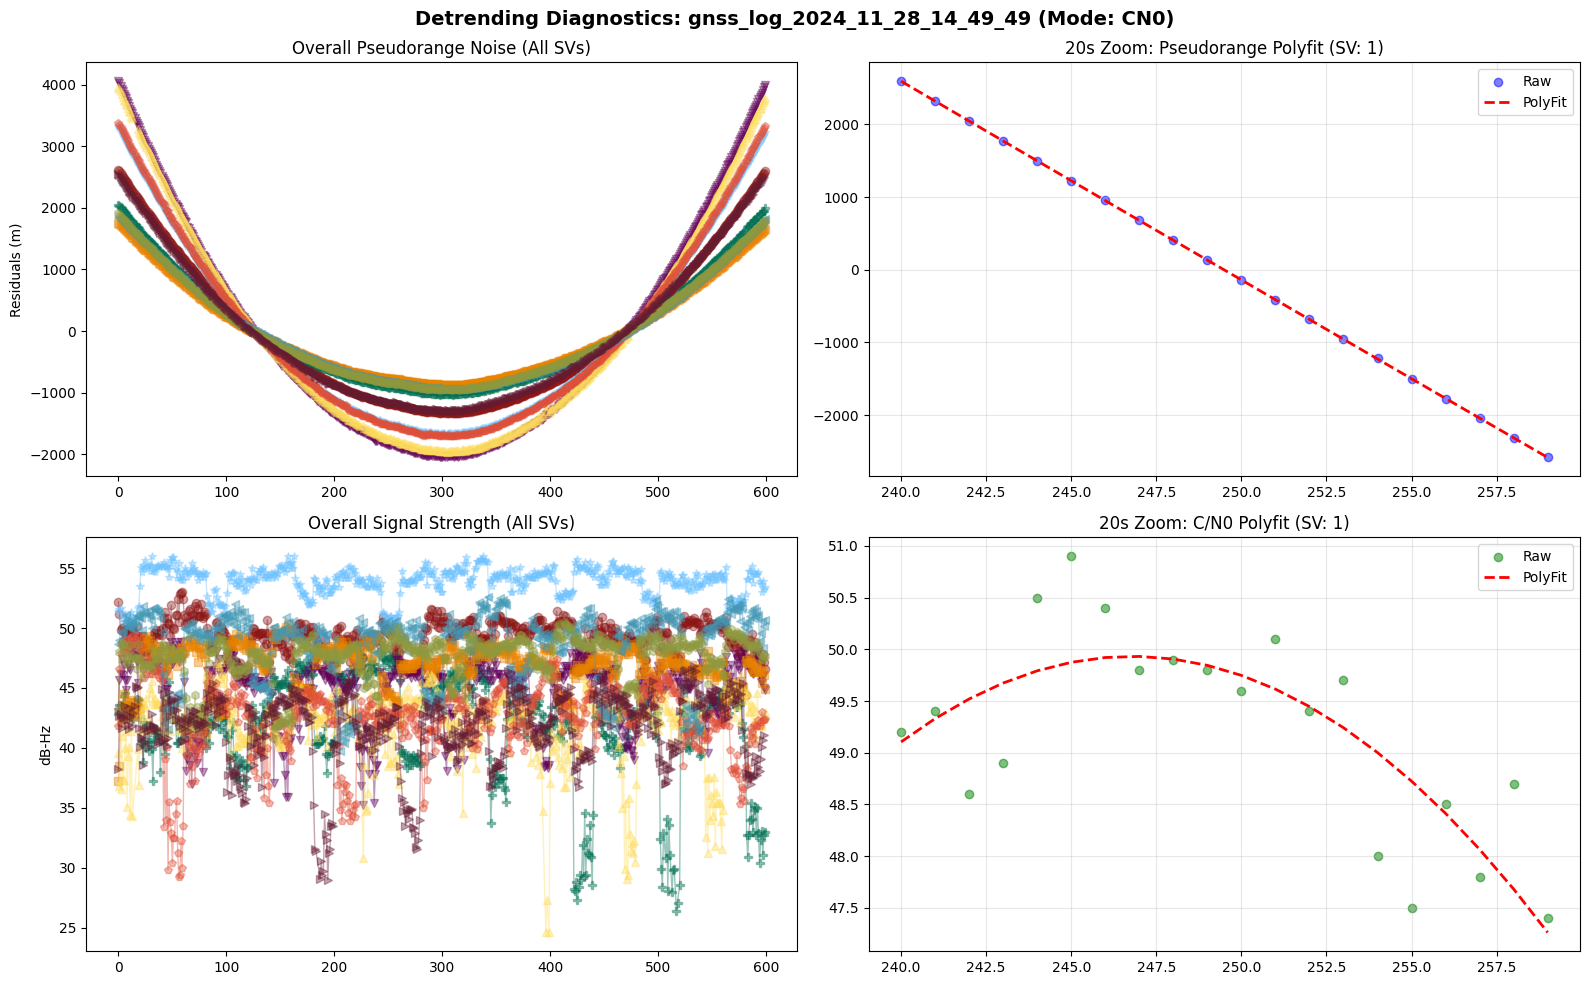

  -> Generated 30 samples.

PROCESSING: gnss_log_2024_11_28_15_01_08.24o -> /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_PR (Mode: PR)


Extracting Data:   0%|          | 0/600 [00:00<?, ?it/s]

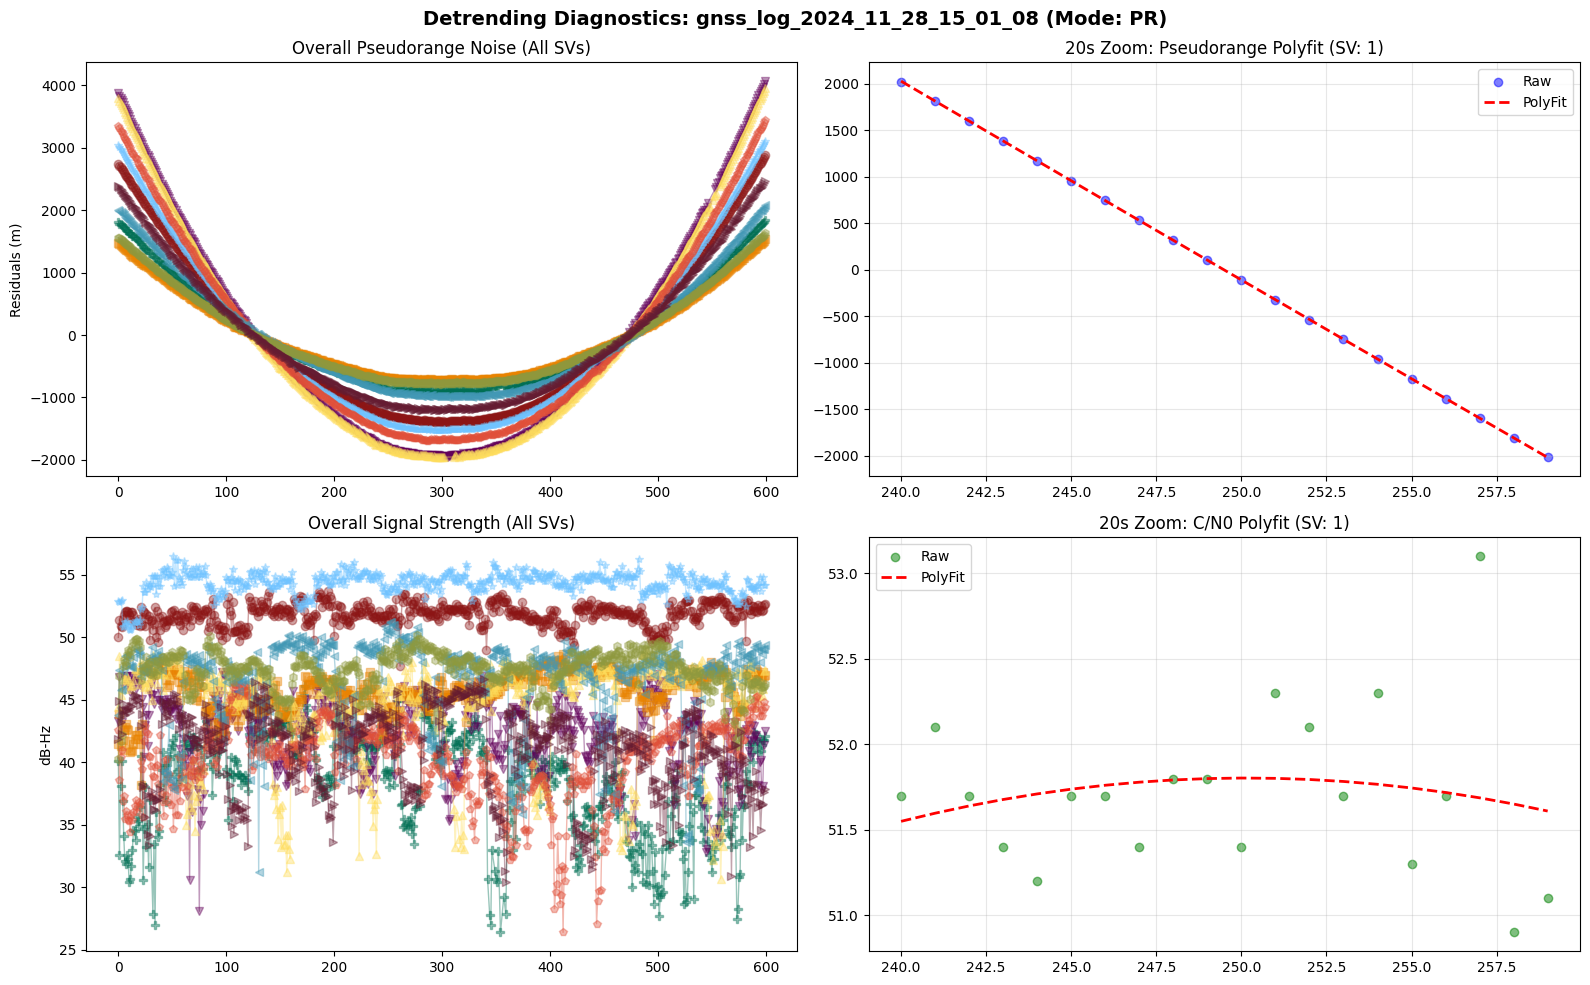

  -> Generated 30 samples.

PROCESSING: gnss_log_2024_11_28_15_01_08.24o -> /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_CN0 (Mode: CN0)


Extracting Data:   0%|          | 0/600 [00:00<?, ?it/s]

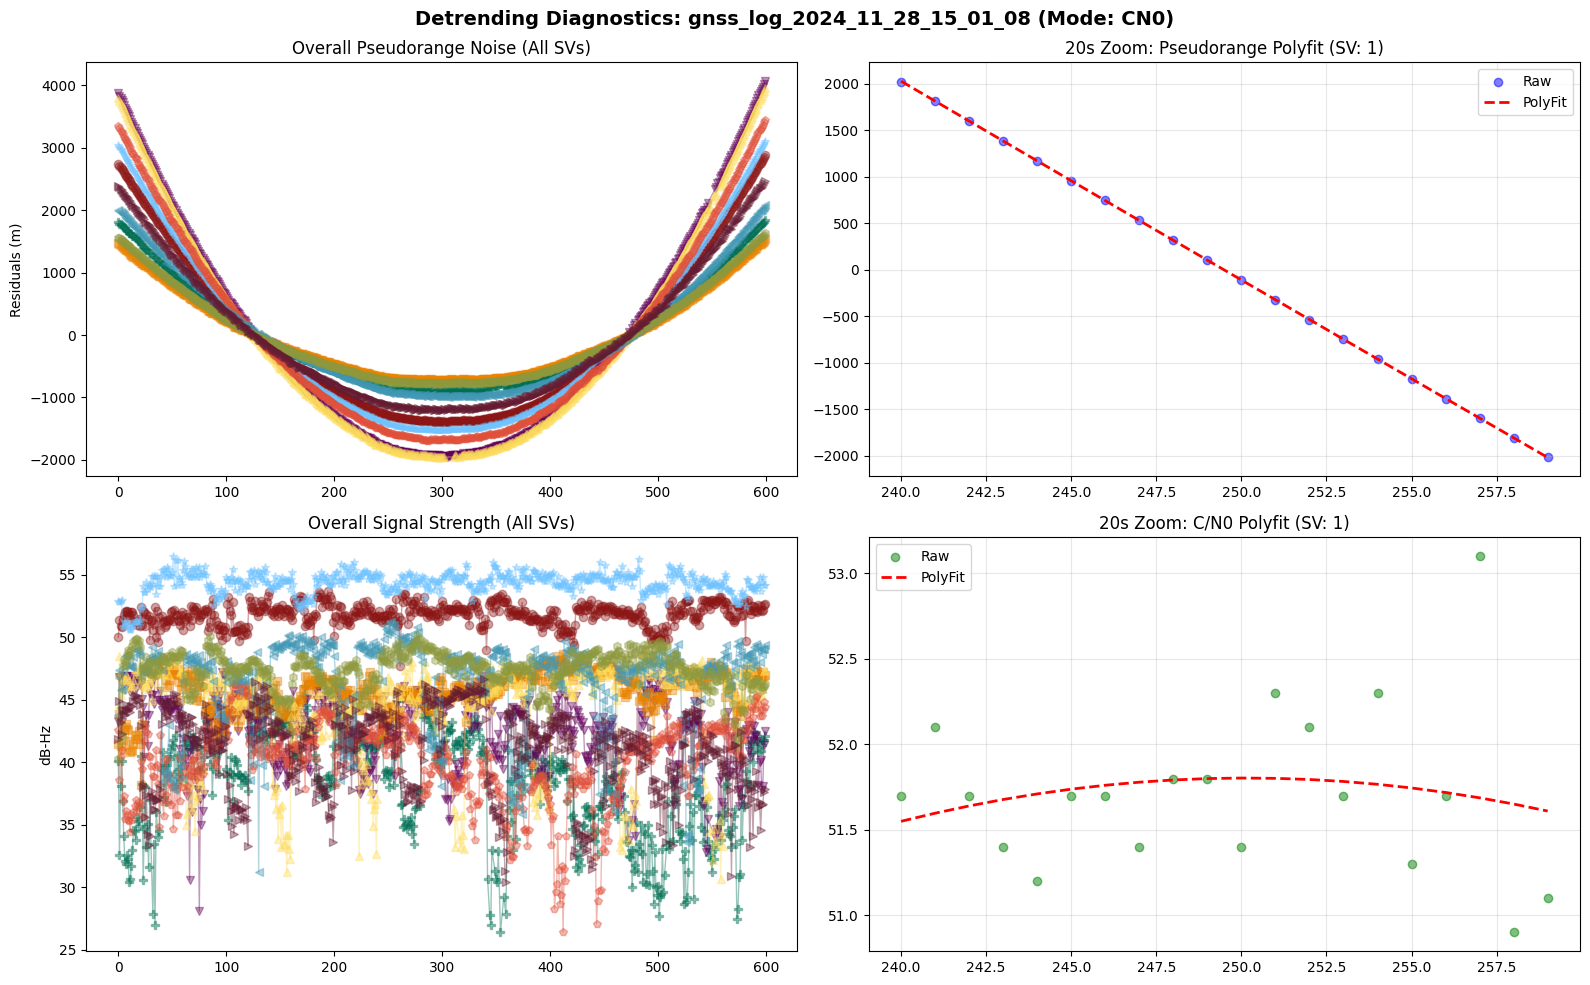

  -> Generated 30 samples.

PROCESSING: gnss_log_2024_11_28_15_11_20.24o -> /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_PR (Mode: PR)


Extracting Data:   0%|          | 0/600 [00:00<?, ?it/s]

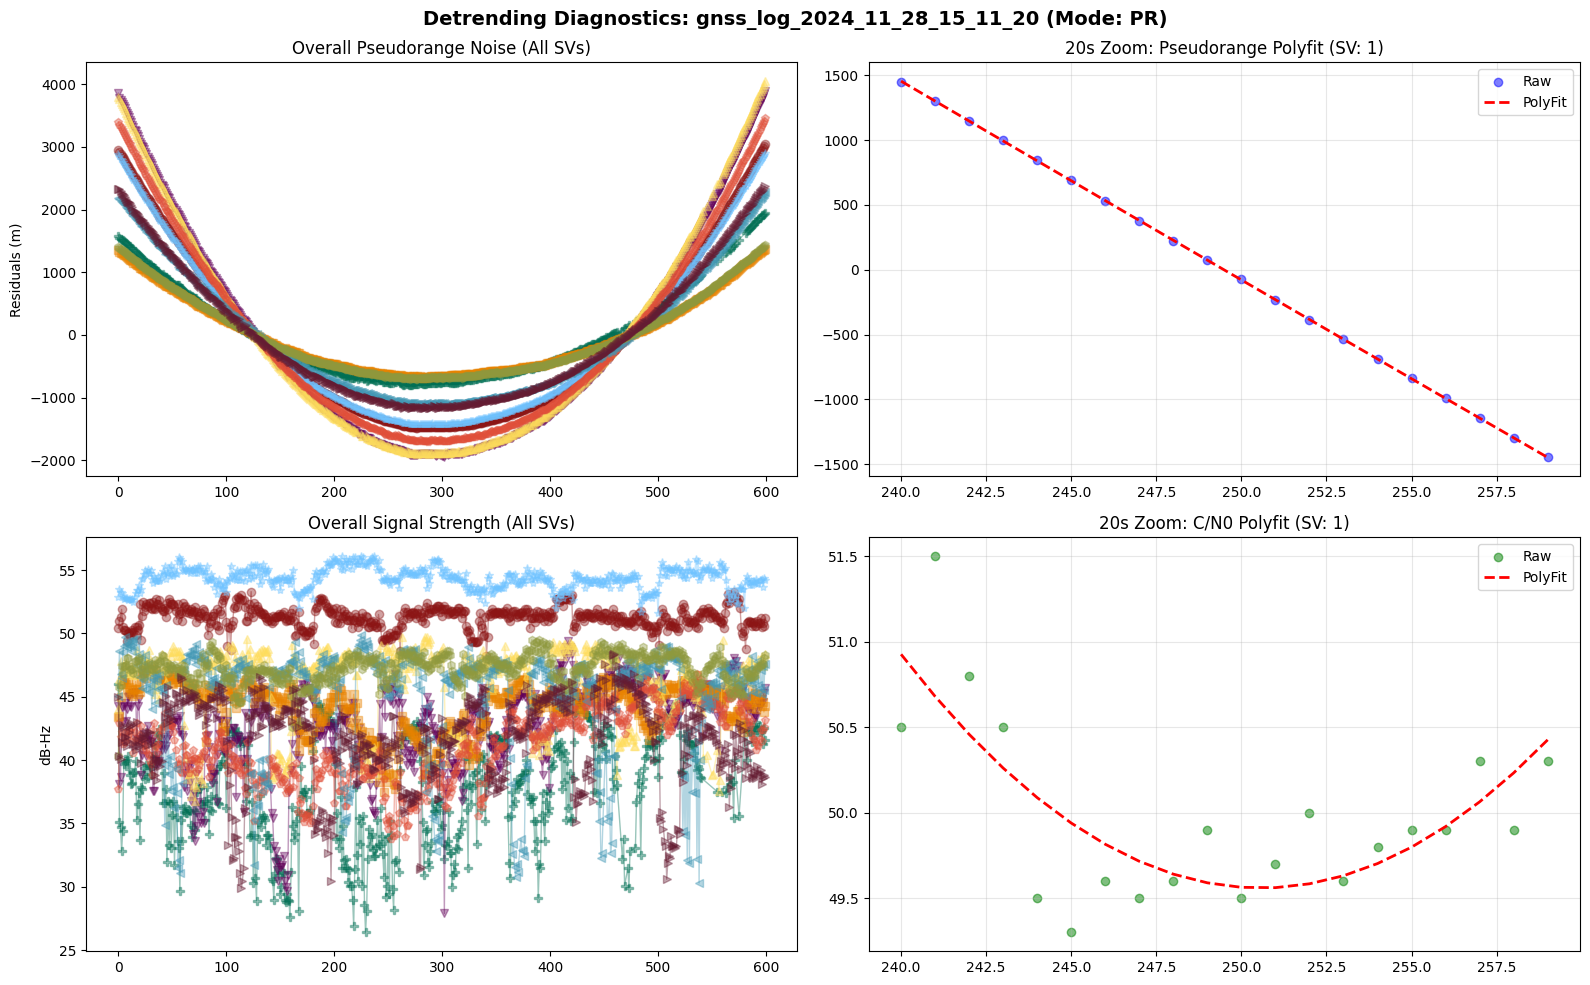

  -> Generated 30 samples.

PROCESSING: gnss_log_2024_11_28_15_11_20.24o -> /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_CN0 (Mode: CN0)


Extracting Data:   0%|          | 0/600 [00:00<?, ?it/s]

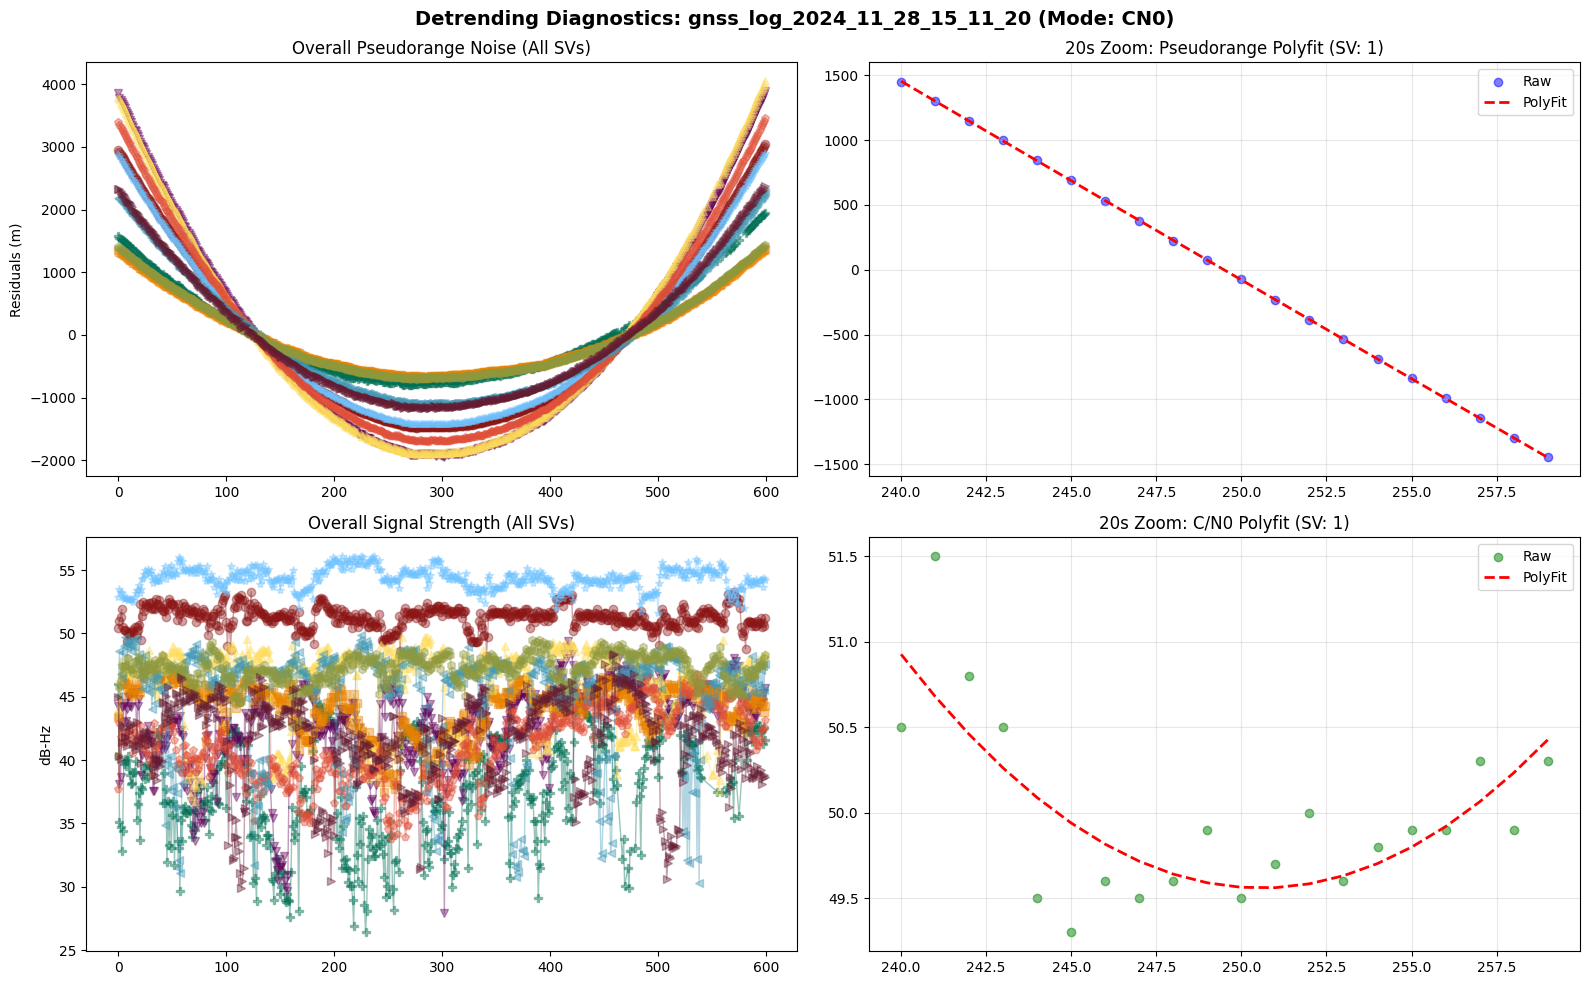

  -> Generated 30 samples.

PROCESSING: gnss_log_2024_11_28_15_21_39.24o -> /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_PR (Mode: PR)


Extracting Data:   0%|          | 0/600 [00:00<?, ?it/s]

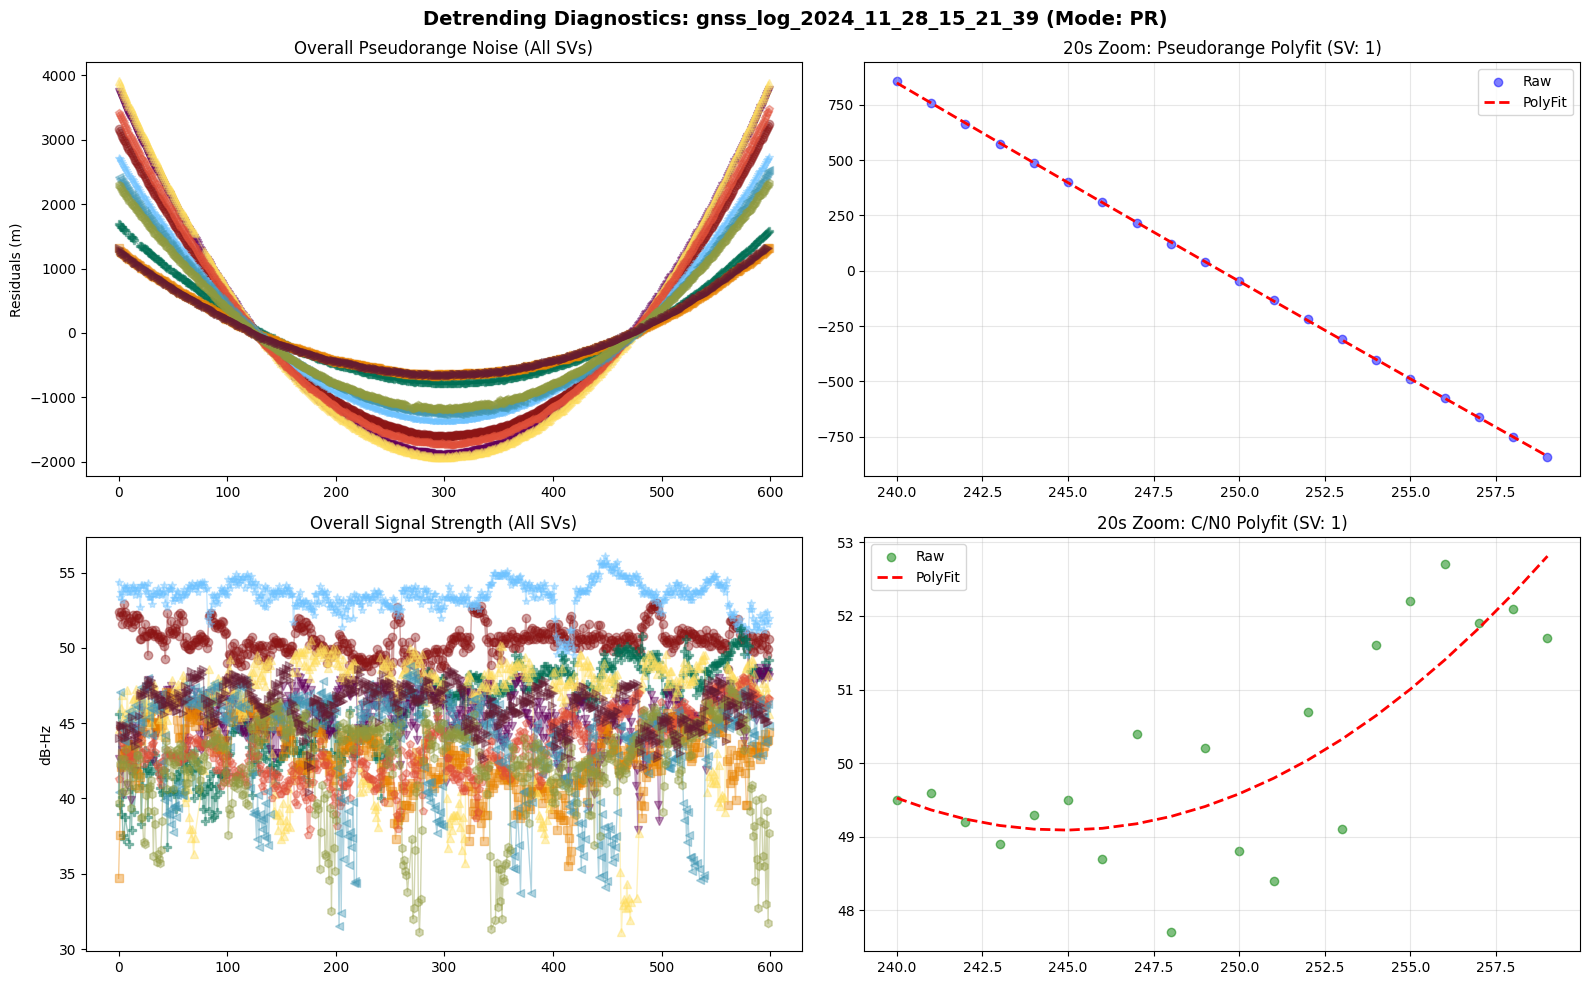

  -> Generated 30 samples.

PROCESSING: gnss_log_2024_11_28_15_21_39.24o -> /content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_CN0 (Mode: CN0)


Extracting Data:   0%|          | 0/600 [00:00<?, ?it/s]

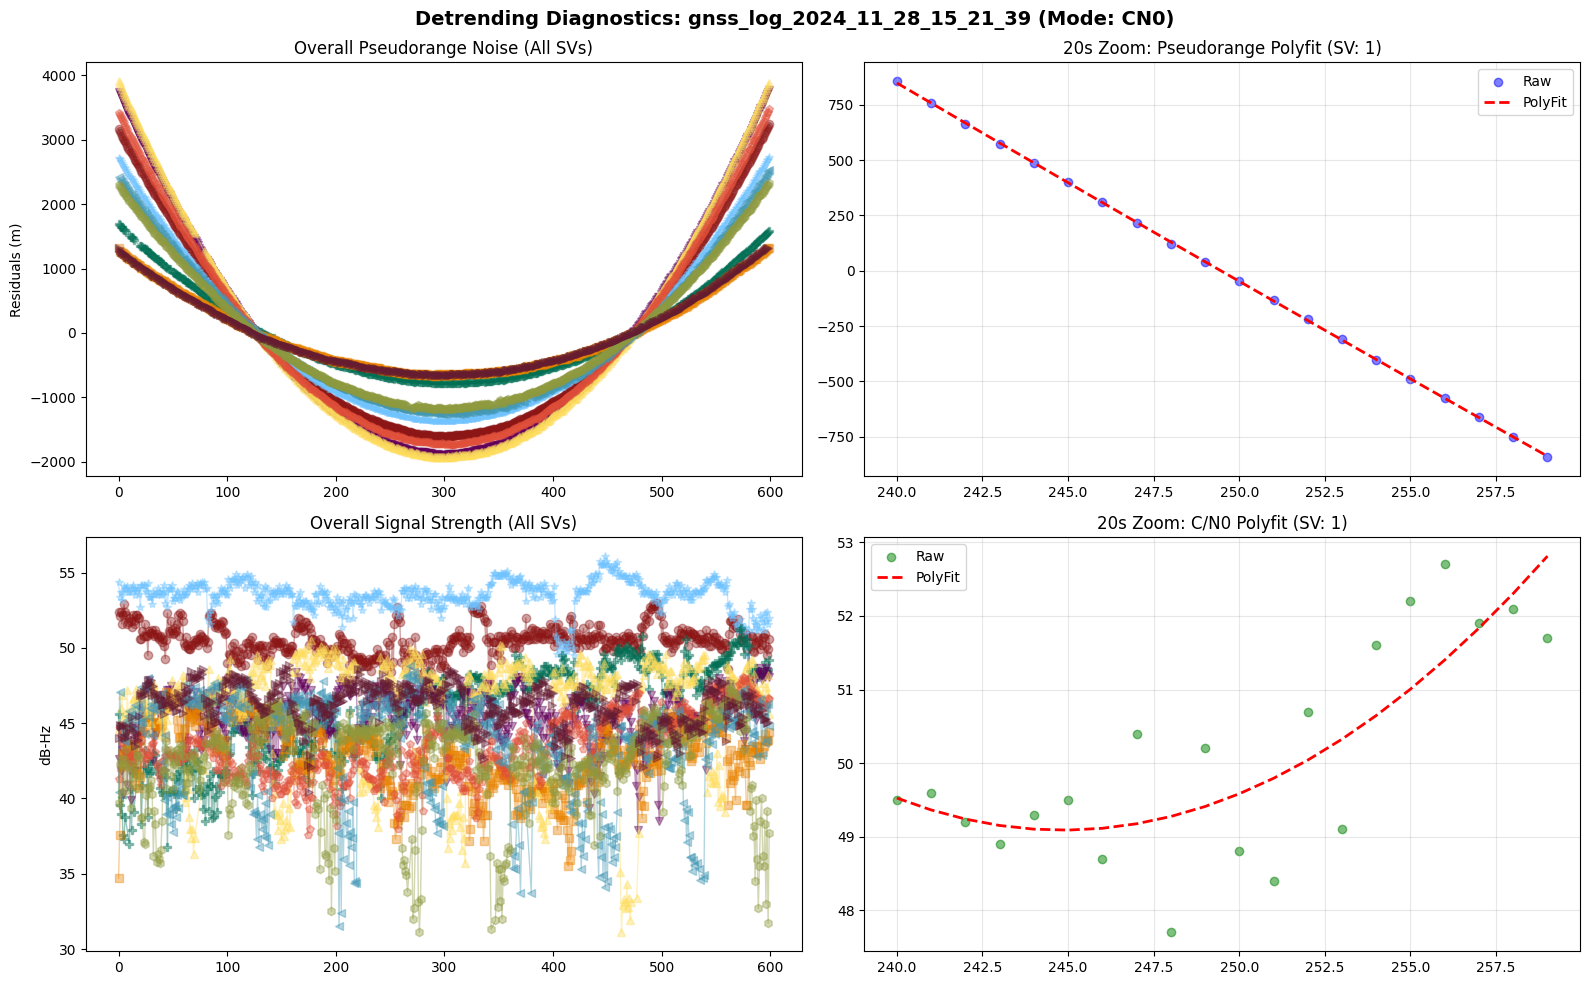

  -> Generated 30 samples.

STEP 2: Upload the 1 'BASELINE' (Empty) log...

PROCESSING: gnss_log_2024_11_28_15_32_09.24o -> /content/drive/MyDrive/AA272/GPS_Project/training_tensors_EMPTY_PR (Mode: PR)


Extracting Data:   0%|          | 0/1800 [00:00<?, ?it/s]

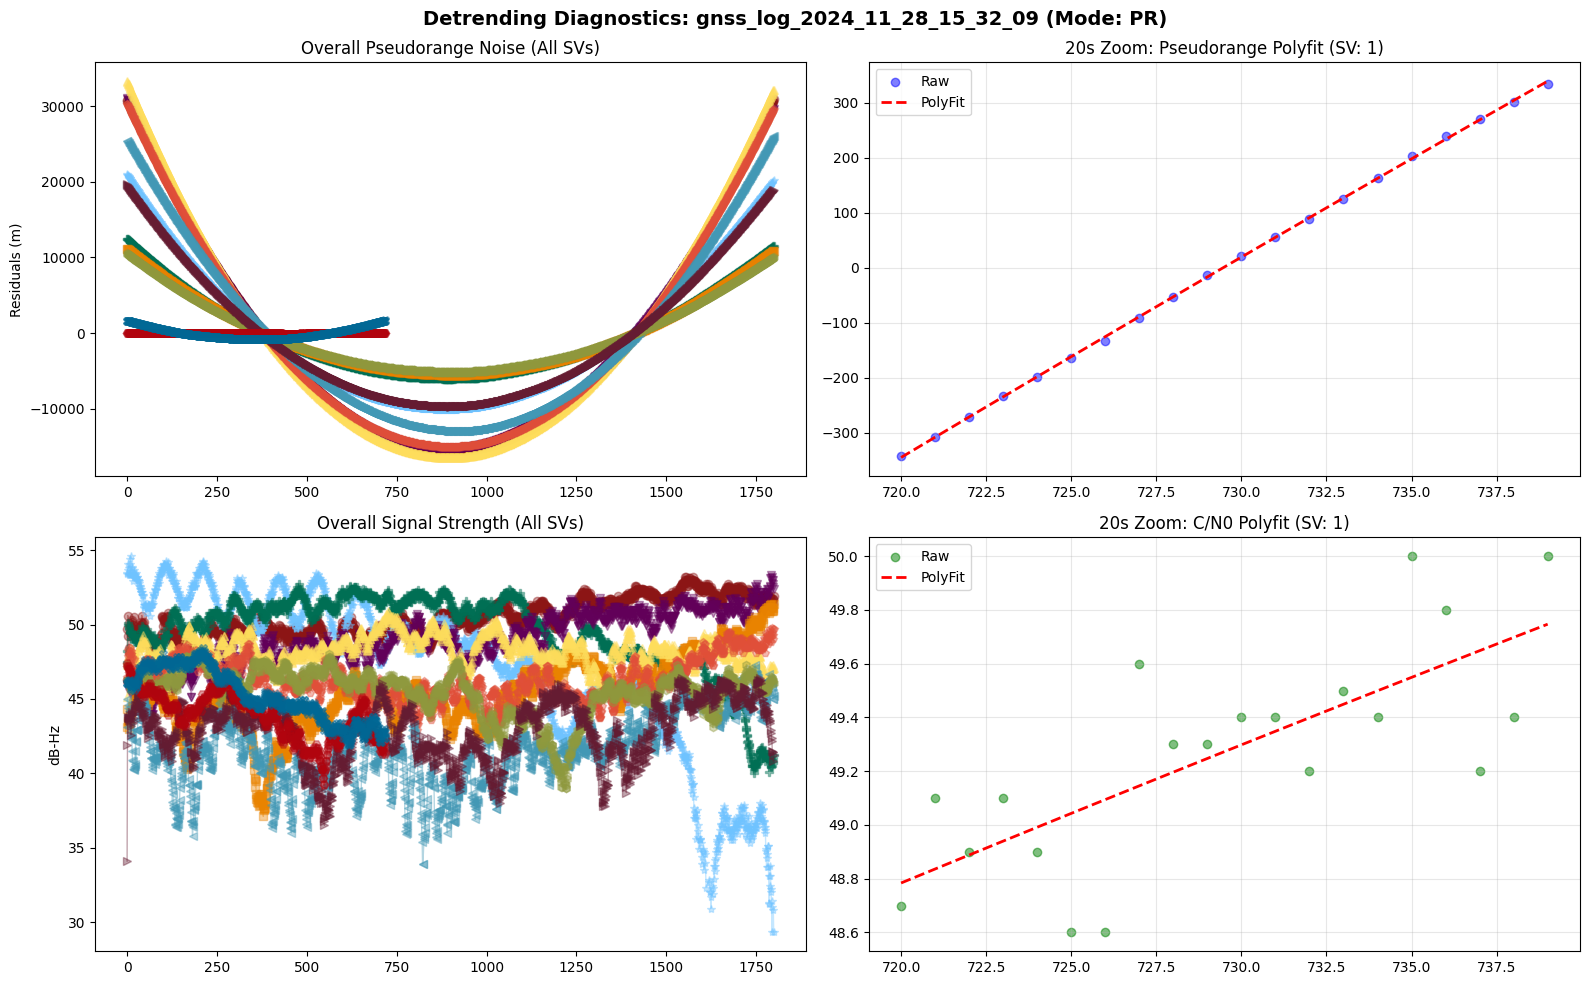

  -> Generated 90 samples.

PROCESSING: gnss_log_2024_11_28_15_32_09.24o -> /content/drive/MyDrive/AA272/GPS_Project/training_tensors_EMPTY_CN0 (Mode: CN0)


Extracting Data:   0%|          | 0/1800 [00:00<?, ?it/s]

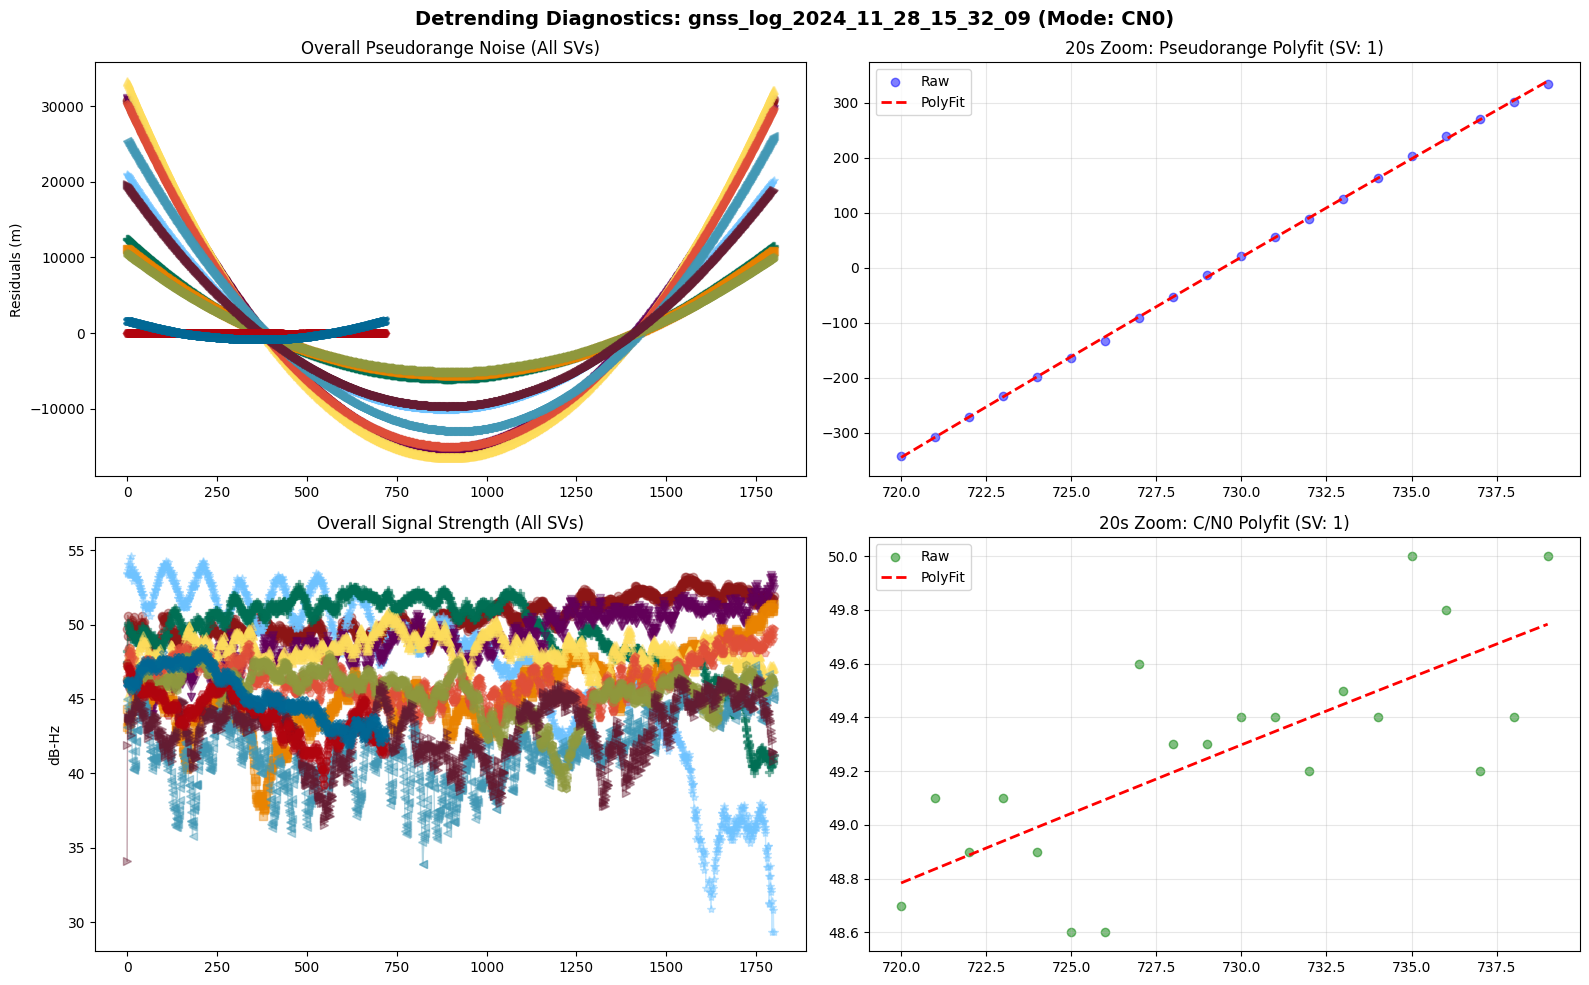

  -> Generated 90 samples.

Processing Complete. Have two datasets.


In [ ]:
# Execution
print("STEP 1: Upload the 4 'ACTIVE' (Rotating) logs...")
uploaded_active = files.upload()

print("\nSTEP 2: Upload the 1 'BASELINE' (Empty) log...")
uploaded_baseline = files.upload()

# process active files
for fname in uploaded_active:
    # Pseudorange
    process_rotating_log(fname, is_baseline=False, metric="pr")
    # Signal Strength
    process_rotating_log(fname, is_baseline=False, metric="cn0")

print("\nSTEP 2: Upload the 1 'BASELINE' (Empty) log...")
# If variables are lost, uncomment the next line:
# uploaded_baseline = files.upload()

# Process Baseline File
for fname in uploaded_baseline:
    process_rotating_log(fname, is_baseline=True, metric="pr")
    process_rotating_log(fname, is_baseline=True, metric="cn0")

print("\nProcessing Complete. Have two datasets.")

Loading Pseudorange Data...
Loading C/N0 Data...


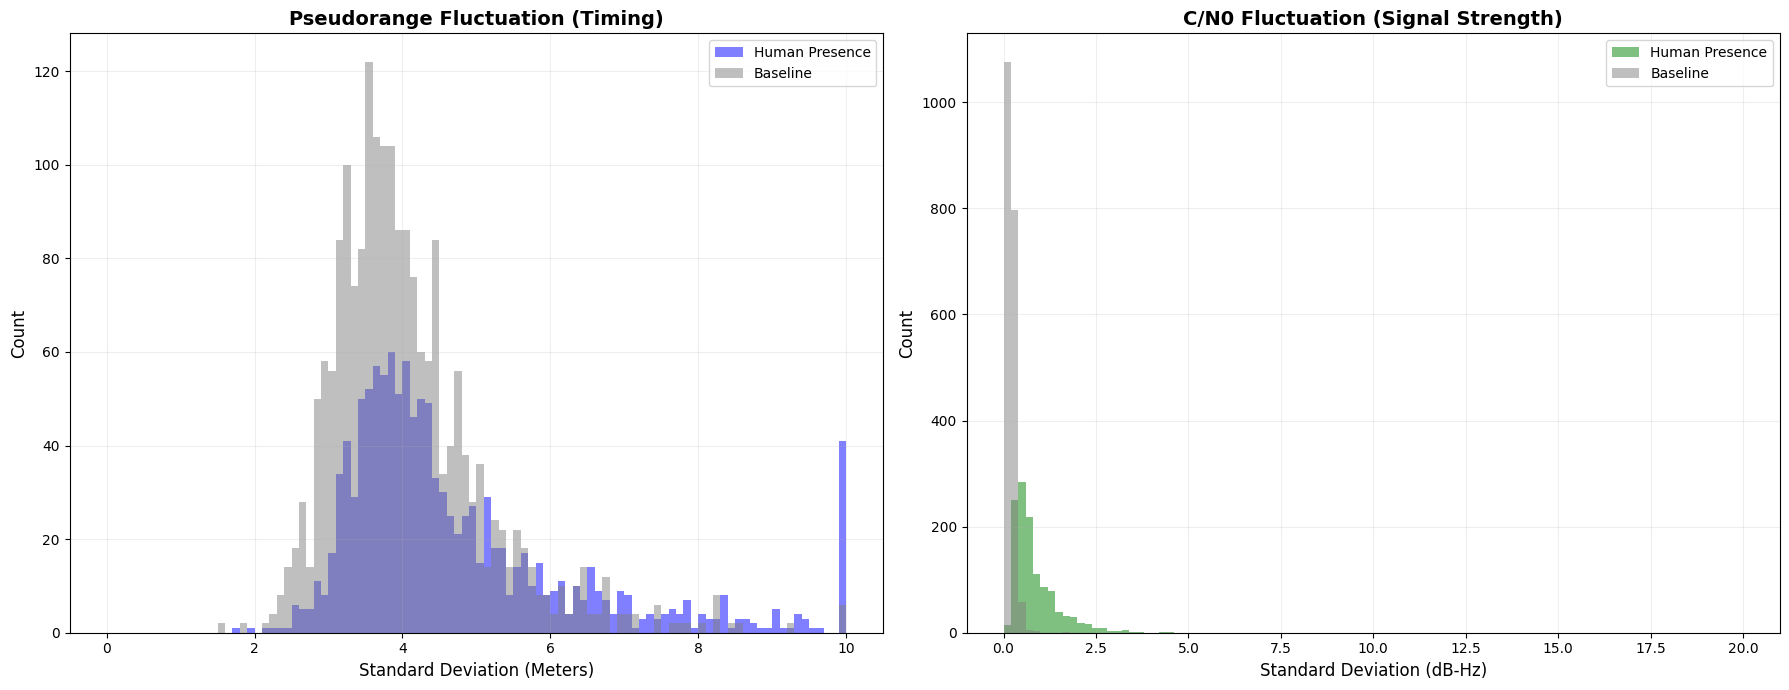

In [ ]:
import glob

#  Histogram (PR vs CN0)

def plot_dual_metric_histograms():
    # Define the 4 folders
    dir_pr_human = os.path.join(PROJECT_ROOT, "training_tensors_ROTATING_PR")
    dir_pr_empty = os.path.join(PROJECT_ROOT, "training_tensors_EMPTY_PR")

    dir_cn0_human = os.path.join(PROJECT_ROOT, "training_tensors_ROTATING_CN0")
    dir_cn0_empty = os.path.join(PROJECT_ROOT, "training_tensors_EMPTY_CN0")

    # load data w helper
    def get_distribution(folder):
        if not os.path.exists(folder):
            print(f"WARNING: Folder not found: {folder}")
            return np.array([])

        files = glob.glob(os.path.join(folder, "*.npy"))
        vals = []
        for f in files:
            grid = np.load(f)
            # Filter > 0.1 to ignore dead sky pixels
            active = grid[grid > 0.1]
            vals.extend(active)
        return np.array(vals)

    print("Loading Pseudorange Data...")
    pr_h = get_distribution(dir_pr_human)
    pr_e = get_distribution(dir_pr_empty)

    print("Loading C/N0 Data...")
    cn0_h = get_distribution(dir_cn0_human)
    cn0_e = get_distribution(dir_cn0_empty)

    # Setup Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # PSEUDORANGE
    if len(pr_h) > 0 and len(pr_e) > 0:
        ax1.hist(pr_h, bins=100, range=(0, 10), density=False, color='blue', alpha=0.5, label='Human Presence')
        ax1.hist(pr_e, bins=100, range=(0, 10), density=False, color='gray', alpha=0.5, label='Baseline')
        ax1.set_title("Pseudorange Fluctuation (Timing)", fontsize=14, fontweight='bold')
        ax1.set_xlabel("Standard Deviation (Meters)", fontsize=12)
        ax1.set_ylabel("Count", fontsize=12)
        ax1.legend()
        ax1.grid(True, which="both", alpha=0.2)
    else:
        ax1.text(0.5, 0.5, "No PR Data Found", ha='center')

    # C/N0
    if len(cn0_h) > 0 and len(cn0_e) > 0:
        # CN0 fluctuations are in dB, so the range is usually wider (0-20)
        ax2.hist(cn0_h, bins=100, range=(0, 20), density=False, color='green', alpha=0.5, label='Human Presence')
        ax2.hist(cn0_e, bins=100, range=(0, 20), density=False, color='gray', alpha=0.5, label='Baseline')
        ax2.set_title("C/N0 Fluctuation (Signal Strength)", fontsize=14, fontweight='bold')
        ax2.set_xlabel("Standard Deviation (dB-Hz)", fontsize=12)
        ax2.set_ylabel("Count", fontsize=12)
        ax2.legend()
        ax2.grid(True, which="both", alpha=0.2)
    else:
        ax2.text(0.5, 0.5, "No CN0 Data Found", ha='center')

    plt.tight_layout()
    plt.show()

plot_dual_metric_histograms()

In [ ]:
# Polar Visualization (Skyplots)
import matplotlib.patches as patches

def visualize_polar(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classes = {0: "North", 1: "East", 2: "South", 3: "West"}

    # find examples
    found_examples = {}
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                lbl = labels[i].item()
                if lbl not in found_examples:
                    found_examples[lbl] = (
                        inputs[i].cpu().squeeze().numpy(),
                        classes[lbl],
                        classes[preds[i].item()],
                        probs[i][preds[i].item()].item()
                    )
            if len(found_examples) == 4: break

    # Polar Plot
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), subplot_kw={'projection': 'polar'})
    order = [0, 1, 2, 3] # N, E, S, W

    # Grid Definitions for pcolormesh
    # Azimuth: 0 to 360 (18 bins)
    theta = np.deg2rad(np.linspace(0, 360, 19))
    # Elevation: 0 to 90 (6 bins).
    # In polar skyplots, Radius = 90 - Elevation.
    # (Center is 0 radius, Edge is 90 radius).
    # But our data is stored 0->90.
    r = np.linspace(90, 0, 7)

    # We need to mesh them
    T, R = np.meshgrid(theta, r)

    for i, idx in enumerate(order):
        ax = axes[i]

        # orient the plot like a compass
        ax.set_theta_zero_location('N') # North at top
        ax.set_theta_direction(-1)      # Clockwise

        # set radial limits (Horizon at edge)
        ax.set_ylim(0, 90)
        ax.set_yticks([0, 30, 60, 90])
        ax.set_yticklabels(['', '60°', '30°', '0°']) # Labels invert for skyplots

        if idx in found_examples:
            img, true_lbl, pred_lbl, conf = found_examples[idx]

            # THE POLAR HEATMAP
            # We must flip the image vertically because pcolormesh draws from center-out
            # but our data (Row 0) is Horizon (Edge).
            # actually, pcolormesh matches the grid.
            # If R goes 90->0, row 0 maps to 90 (Horizon).

            c = ax.pcolormesh(T, R, img, cmap='viridis', shading='flat', edgecolors='none')

            # RED SECTOR (Ground Truth)
            # We define start/end angles for the pie Slice
            start_angle = 0
            end_angle = 0

            if true_lbl == "North":
                start_angle, end_angle = 315, 45
            elif true_lbl == "East":
                start_angle, end_angle = 45, 135
            elif true_lbl == "South":
                start_angle, end_angle = 135, 225
            elif true_lbl == "West":
                start_angle, end_angle = 225, 315

            # Draw the wedge
            # center=(0,0), r=90 (Horizon), width=45 (Goes up to 45 deg elevation)
            # The wedge slice patch in polar is tricky.... easier to use fill_between
            # But here we can use bar plotting logic for sectors

            # Simplified visualization of the sector using a red outline
            # Convert degrees to radians
            if true_lbl == "North":
                # Need two segments because it crosses 0
                x = np.deg2rad(np.linspace(315, 360, 50))
                ax.plot(x, [45]*50, color='red', linewidth=3, linestyle='--') # Inner arc
                ax.plot(x, [90]*50, color='red', linewidth=3, linestyle='--') # Outer arc
                ax.plot([x[0], x[0]], [45, 90], color='red', linewidth=3, linestyle='--') # Side line

                x2 = np.deg2rad(np.linspace(0, 45, 50))
                ax.plot(x2, [45]*50, color='red', linewidth=3, linestyle='--')
                ax.plot(x2, [90]*50, color='red', linewidth=3, linestyle='--')
                ax.plot([x2[-1], x2[-1]], [45, 90], color='red', linewidth=3, linestyle='--')

            else:
                x = np.deg2rad(np.linspace(start_angle, end_angle, 100))
                # the inner Arc (45 deg elevation = radius 45)
                ax.plot(x, [45]*100, color='red', linewidth=3, linestyle='--')
                # the outer Arc (0 deg elevation = radius 90)
                ax.plot(x, [90]*100, color='red', linewidth=3, linestyle='--')
                # Radial Lines
                ax.plot([x[0], x[0]], [45, 90], color='red', linewidth=3, linestyle='--')
                ax.plot([x[-1], x[-1]], [45, 90], color='red', linewidth=3, linestyle='--')

            # titling
            color = 'green' if true_lbl == pred_lbl else 'red'
            ax.set_title(f"True: {true_lbl}\nPred: {pred_lbl} ({conf*100:.1f}%)",
                         color=color, fontweight='bold', fontsize=14, pad=20)

        else:
            ax.set_title(f"Label {idx} missing")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Full Validation Grid with Blocking Region

def visualize_entire_validation_set(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classes = {0: "North", 1: "East", 2: "South", 3: "West"}

    buckets = {k: [] for k in range(4)}

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                lbl = labels[i].item()
                data_tuple = (
                    inputs[i].cpu().squeeze().numpy(), # Image
                    classes[lbl],                      # True Label Str
                    classes[preds[i].item()],          # Pred Label Str
                    probs[i][preds[i].item()].item()   # Confidence
                )
                buckets[lbl].append(data_tuple)

    max_rows = max(len(v) for v in buckets.values())
    if max_rows == 0:
        print("No validation samples found.")
        return

    print(f"Plotting {sum(len(v) for v in buckets.values())} samples in a {max_rows} (rows) x 4 (cols) grid...")

    # setup Giant Plot
    fig, axes = plt.subplots(max_rows, 4, figsize=(20, 5 * max_rows), subplot_kw={'projection': 'polar'})

    # Handle case where max_rows is 1
    if max_rows == 1: axes = np.expand_dims(axes, 0)

    # grid setup for pcolormesh
    theta = np.deg2rad(np.linspace(0, 360, 19))
    r = np.linspace(90, 0, 7) # r=90 is Horizon, r=0 is Zenith
    T, R = np.meshgrid(theta, r)

    # 4. Loop through grid
    for col in range(4): # Columns correspond to N, E, S, W
        direction_samples = buckets[col]

        for row in range(max_rows):
            ax = axes[row, col]

            # we have a sample for this slot, plot it
            if row < len(direction_samples):
                img, true_lbl, pred_lbl, conf = direction_samples[row]


                ax.set_theta_zero_location('N')
                ax.set_theta_direction(-1)
                ax.set_ylim(0, 90)
                ax.set_yticks([0, 45, 90])
                ax.set_yticklabels([]) # Clean look
                ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])

                # Heatmap
                c = ax.pcolormesh(T, R, img, cmap='viridis', shading='flat', edgecolors='none')

                # DRAWING THE BLOCKING REGION
                # We want: Solid Arcs (Horizon/High El) and Dotted Radials (Azimuth)

                start_angle, end_angle = 0, 0
                if col == 0: start_angle, end_angle = 315, 45   # North
                elif col == 1: start_angle, end_angle = 45, 135 # East
                elif col == 2: start_angle, end_angle = 135, 225 # South
                elif col == 3: start_angle, end_angle = 225, 315 # West


                if col == 0: # North split (crosses 0/360 boundary)
                    # 1: 315 to 360
                    x1 = np.deg2rad(np.linspace(315, 360, 20))
                    ax.plot(x1, [45]*20, 'r-', lw=2)  #  Inner Arc (High El)
                    ax.plot(x1, [90]*20, 'r-', lw=3)  #  Outer Arc (Horizon)
                    ax.plot([x1[0], x1[0]], [45, 90], 'r:', lw=2) # Dotted Radial (Left Edge)

                    # 2: 0 to 45
                    x2 = np.deg2rad(np.linspace(0, 45, 20))
                    ax.plot(x2, [45]*20, 'r-', lw=2)  #  Inner Arc
                    ax.plot(x2, [90]*20, 'r-', lw=3)  #  Outer Arc
                    ax.plot([x2[-1], x2[-1]], [45, 90], 'r:', lw=2) # Dotted Radial (Right Edge)

                else:
                    # East, South, West (Continuous)
                    x = np.deg2rad(np.linspace(start_angle, end_angle, 40))

                    # Solid Arcs
                    ax.plot(x, [45]*40, 'r-', lw=2) # High Elevation (45 deg)
                    ax.plot(x, [90]*40, 'r-', lw=3) # Horizon (0 deg)

                    # Dotted Radials
                    ax.plot([x[0], x[0]], [45, 90], 'r:', lw=2)   # Left Azimuth Boundary
                    ax.plot([x[-1], x[-1]], [45, 90], 'r:', lw=2) # Right Azimuth Boundary

                # Title
                color = 'green' if true_lbl == pred_lbl else 'red'
                ax.set_title(f"Pred: {pred_lbl}\n({conf*100:.1f}%)",
                             color=color, fontweight='bold', fontsize=12)

            else:
                # Empty slot
                ax.axis('off')

    fig.text(0.15, 0.99, "NORTH SAMPLES", ha='center', fontsize=18, fontweight='bold')
    fig.text(0.38, 0.99, "EAST SAMPLES", ha='center', fontsize=18, fontweight='bold')
    fig.text(0.62, 0.99, "SOUTH SAMPLES", ha='center', fontsize=18, fontweight='bold')
    fig.text(0.85, 0.99, "WEST SAMPLES", ha='center', fontsize=18, fontweight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

In [ ]:
# inal Report

def evaluate_model_performance(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    correct = 0
    total = 0

    # Per-class counters
    class_correct = list(0. for i in range(4))
    class_total = list(0. for i in range(4))
    classes = {0: "North", 1: "East", 2: "South", 3: "West"}

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Global Accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Per-Class Accuracy
            c = (predicted == labels).squeeze()
            # Handle batch size of 1
            if c.ndim == 0:
                label = labels.item()
                class_correct[label] += c.item()
                class_total[label] += 1
            else:
                for i in range(len(labels)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

    print("="*40)
    print("FINAL PERFORMANCE REPORT")
    print("="*40)

    # Overall Accuracy
    overall_acc = 100 * correct / total
    print(f"OVERALL ACCURACY:   {overall_acc:.2f}%")
    print("-" * 40)

    # Accuracy by Direction
    print("BREAKDOWN BY DIRECTION:")
    for i in range(4):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f"  {classes[i]:<5} : {acc:.1f}%  ({int(class_correct[i])}/{int(class_total[i])})")
        else:
            print(f"  {classes[i]:<5} : N/A    (No samples in validation set)")

    print("="*40)

Training on 96 samples...
Epoch 5 | Acc: 46.9%
Epoch 10 | Acc: 61.5%
Epoch 15 | Acc: 68.8%
Epoch 20 | Acc: 75.0%
Epoch 25 | Acc: 72.9%
Epoch 30 | Acc: 74.0%
Epoch 35 | Acc: 78.1%
Epoch 40 | Acc: 85.4%
Epoch 45 | Acc: 82.3%
Epoch 50 | Acc: 79.2%
Epoch 55 | Acc: 83.3%
Epoch 60 | Acc: 89.6%
Epoch 65 | Acc: 93.8%
Epoch 70 | Acc: 88.5%
Epoch 75 | Acc: 90.6%
Epoch 80 | Acc: 86.5%
Epoch 85 | Acc: 83.3%
Epoch 90 | Acc: 90.6%
Epoch 95 | Acc: 88.5%
Epoch 100 | Acc: 87.5%
Training Done. Generating Visualizations...
Plotting 24 samples in a 11 (rows) x 4 (cols) grid...


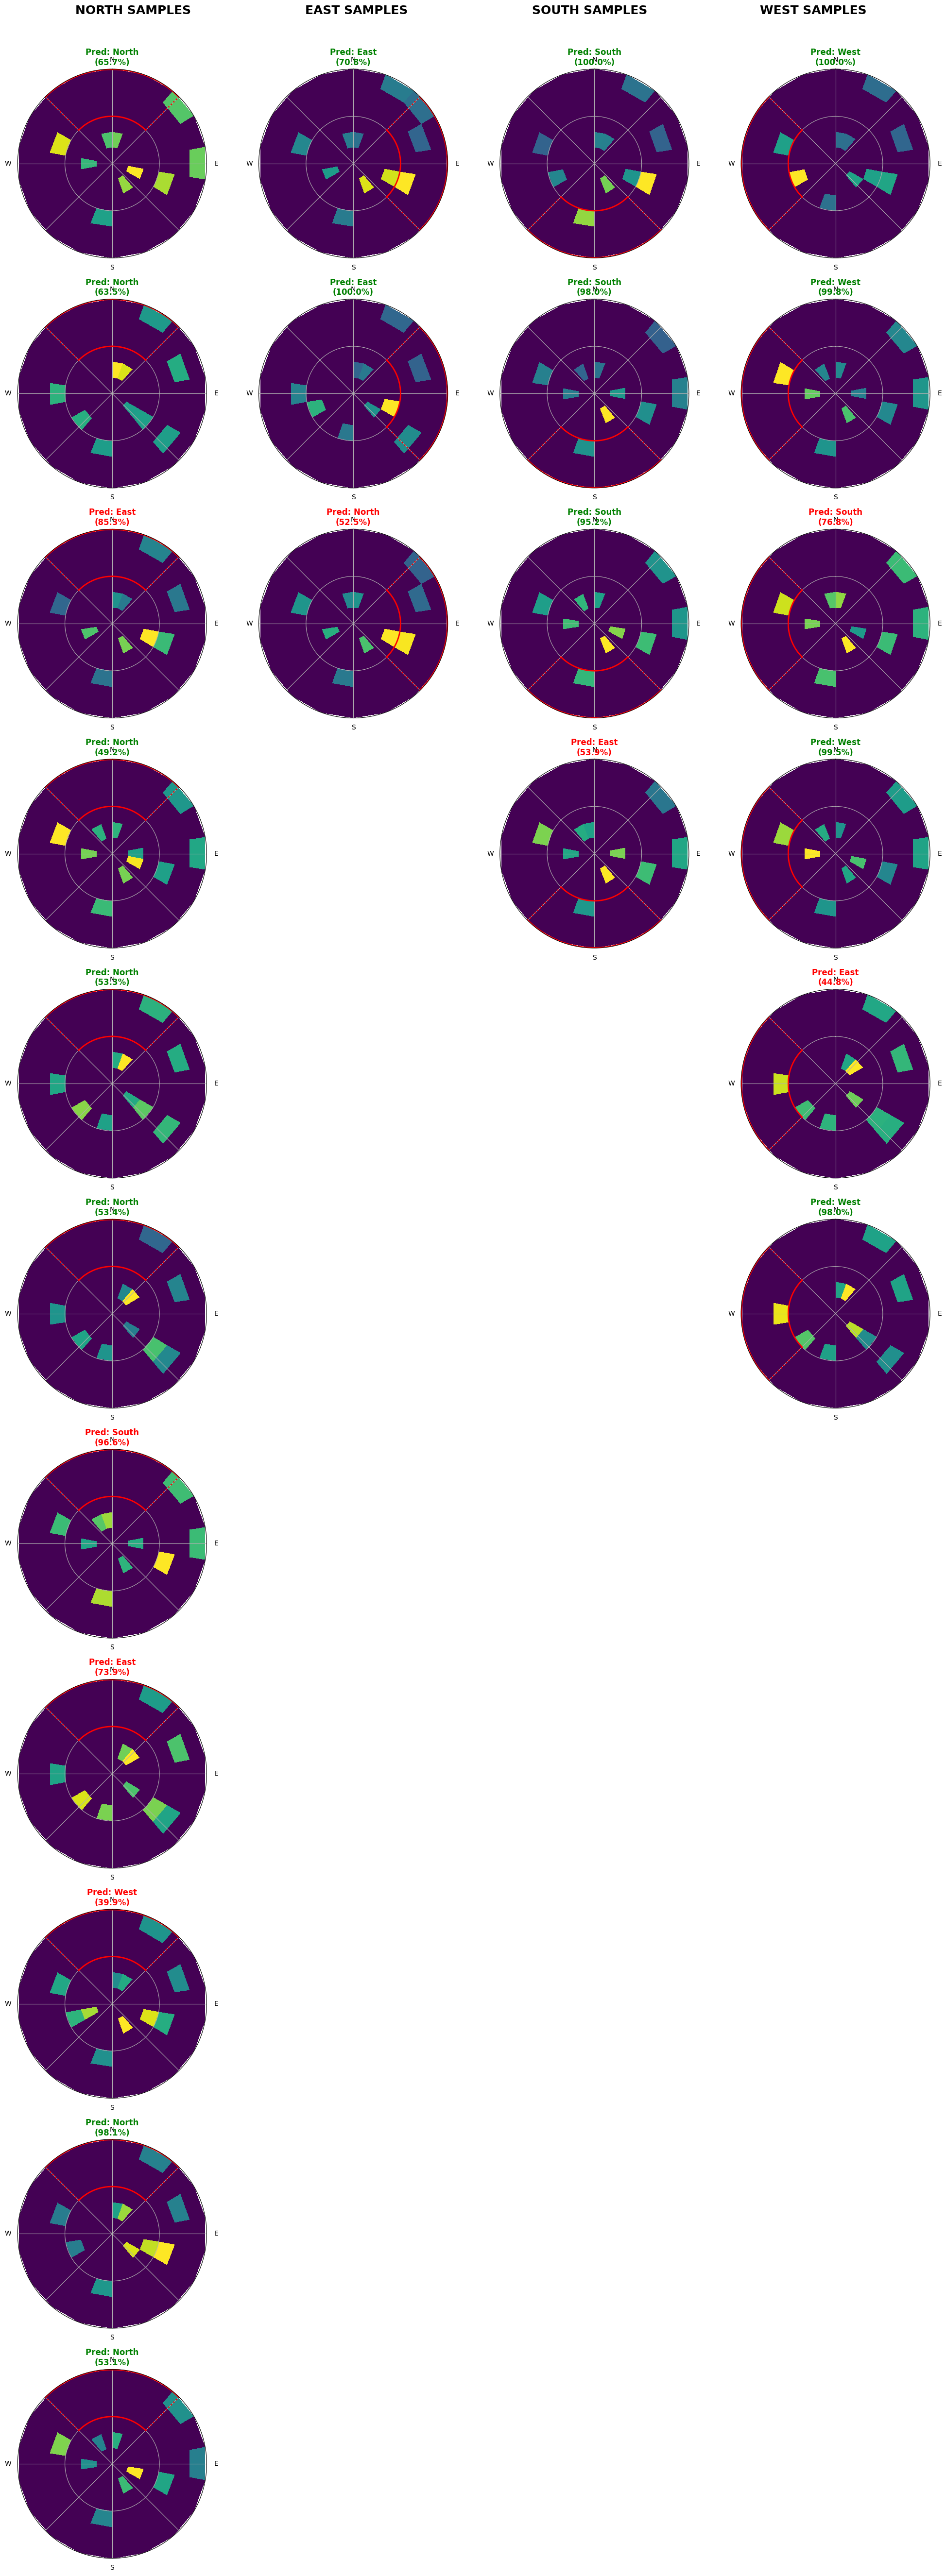

FINAL PERFORMANCE REPORT
OVERALL ACCURACY:   66.67%
----------------------------------------
BREAKDOWN BY DIRECTION:
  North : 63.6%  (7/11)
  East  : 66.7%  (2/3)
  South : 75.0%  (3/4)
  West  : 66.7%  (4/6)


In [ ]:
#  Train with Metric Selection

from torch.utils.data import Dataset, DataLoader
import glob
import torch
import torch.nn as nn
import numpy as np
import os

class GNSSDataset(Dataset):
    def __init__(self, dir_path, noise_threshold=1.0):
        self.files = glob.glob(os.path.join(dir_path, "*.npy"))
        self.noise_threshold = noise_threshold

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        filename = os.path.basename(path)

        # filename parsing
        # Format: "gnss_log_name_0_North_0001.npy"
        parts = filename.split('_')
        try:
            # ID is at index -3 (e.g., ..._0_North_0001.npy -> 0)
            label = int(parts[-3])
        except ValueError:
            # Fallback
            label = int(parts[0])

        # Load the grid
        grid = np.load(path)

        # Noise Gate? Noooooo!!
        # Mask clean satellites to 0.0
        grid[grid < self.noise_threshold] = 0.0

        tensor = torch.from_numpy(grid).float().unsqueeze(0)
        return tensor, label

def train_rotating_model():
    # 1. Choose Dataset (Comment/Uncomment the one you want)

    # OPTION A: Pseudorange (Timing)
    dataset = GNSSDataset(
        dir_path="/content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_PR",
        noise_threshold=1.5  # ~1.5m is typical for PR
    )

    # OPTION B: C/N0 (Signal Strength)
    # dataset = GNSSDataset(
    #     dir_path="/content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_CN0",
    #     noise_threshold=0  # ~1.5 dB is typical for CN0
    # )

    if len(dataset) == 0:
        print("No data found. Did you run the processor cell?")
        return None

    # Split
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

    # Model
    sample, _ = dataset[0]
    _, h, w = sample.shape
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GPSCompassCNN(h, w).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print(f"Training on {len(train_ds)} samples...")

    # Training Loop
    EPOCHS = 100
    for epoch in range(EPOCHS):
        model.train()
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1} | Acc: {100*correct/total:.1f}%")

    print("Training Done. Generating Visualizations...")

    # Detailed Evaluation (With Axes)
    # if 'visualize_polar' in globals():
    if 'visualize_entire_validation_set' in globals():
        # visualize_polar(model, val_loader)
        visualize_entire_validation_set(model, val_loader)
    else:
        print("Visualization function missing. Run Cell 16 first.")

    #  Evaluation Report
    if 'evaluate_model_performance' in globals():
        evaluate_model_performance(model, val_loader)
    else:
        print("Evaluation function missing. Run Cell def first.")

    return model

# Run it
trained_model = train_rotating_model()

## PR vs CN0 Analysis

In [ ]:
# CELL 1: Experiment Setup
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Define Paths (Based on previous dual-mode generation)
DIR_PR = "/content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_PR"
DIR_CN0 = "/content/drive/MyDrive/AA272/GPS_Project/training_tensors_ROTATING_CN0"

# Standard Model (1-Channel)
class GPSCompassCNN(nn.Module):
    def __init__(self, height, width, num_classes=4):
        super(GPSCompassCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.flat_size = 32 * (height // 2) * (width // 2)
        self.fc1 = nn.Linear(self.flat_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

class EvaluationDataset(Dataset):
    def __init__(self, dir_path, noise_threshold):
        # Grab all .npy files (excluding empty/baseline logs)
        all_files = glob.glob(os.path.join(dir_path, "*.npy"))
        self.files = [f for f in all_files if "Empty" not in f]
        self.noise_threshold = noise_threshold

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        filename = os.path.basename(path)
        try:
            # Parse filename like "gnss_log_name_0_North_0001.npy"
            label = int(filename.split('_')[-3])
        except:
            label = 0

        grid = np.load(path)
        grid[grid < self.noise_threshold] = 0.0 # Noise Gate
        tensor = torch.from_numpy(grid).float().unsqueeze(0)
        return tensor, label

In [ ]:
# Single Run Training Function

def train_single_run(data_dir, metric_name, run_id, num_epochs=100):
    # 1. Setup Parameters based on Metric
    # PR usually needs ~1.0m threshold, CN0 needs ~1.5 - 2.0 dB
    thresh = 0.0 # if metric_name == "PR" else 2.0

    dataset = EvaluationDataset(data_dir, noise_threshold=thresh)

    # 80/20 Split
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

    # 2. Init Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Get shape from first sample
    sample, _ = dataset[0]
    model = GPSCompassCNN(sample.shape[1], sample.shape[2]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # 3. Fast Training Loop no  printing
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # 4. Final Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
# Execution Loop

NUM_TRIALS = 10  # Number of times to train EACH method
EPOCHS_PER_RUN = 100


results_pr = []
results_cn0 = []

print(f"Starting Monte Carlo Simulation: {NUM_TRIALS} runs per method.")
print(f"Total Models to Train: {NUM_TRIALS * 2}")
print("="*60)

# 1. Run Pseudorange Trials
print(">>> Phase 1: Pseudorange (PR) Trials")
for i in tqdm(range(NUM_TRIALS), desc="PR Runs"):
    acc = train_single_run(DIR_PR, "PR", i, num_epochs=EPOCHS_PER_RUN)
    results_pr.append(acc)

# 2. Run C/N0 Trials
print("\n>>> Phase 2: Signal Strength (CN0) Trials")
for i in tqdm(range(NUM_TRIALS), desc="CN0 Runs"):
    acc = train_single_run(DIR_CN0, "CN0", i, num_epochs=EPOCHS_PER_RUN)
    results_cn0.append(acc)

print("\nSimulation Complete.")
print(f"PR Average:  {np.mean(results_pr):.2f}% (Std: {np.std(results_pr):.2f})")
print(f"CN0 Average: {np.mean(results_cn0):.2f}% (Std: {np.std(results_cn0):.2f})")

Starting Monte Carlo Simulation: 10 runs per method.
Total Models to Train: 20
>>> Phase 1: Pseudorange (PR) Trials


PR Runs:   0%|          | 0/10 [00:00<?, ?it/s]


>>> Phase 2: Signal Strength (CN0) Trials


CN0 Runs:   0%|          | 0/10 [00:00<?, ?it/s]


Simulation Complete.
PR Average:  64.58% (Std: 8.59)
CN0 Average: 83.33% (Std: 3.73)


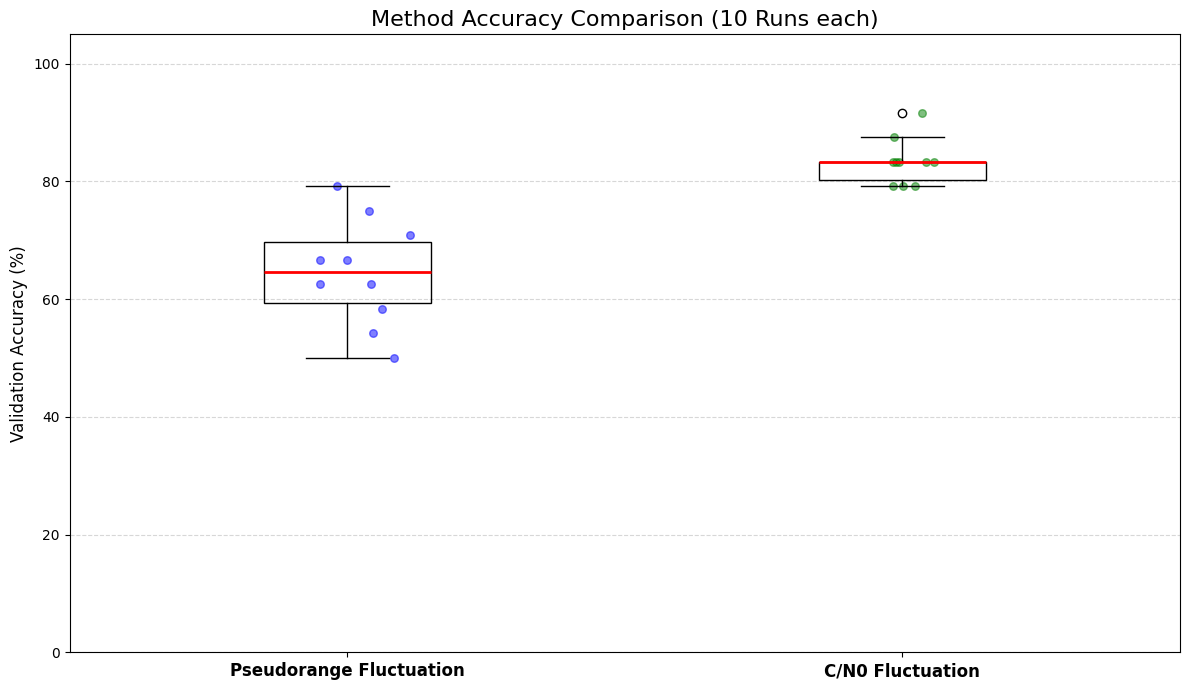

In [ ]:
# Visualization of Accuracy Distribution with Stats

def plot_accuracy_comparison(pr_scores, cn0_scores):
    plt.figure(figsize=(12, 7)) # Made figure slightly wider for text

    x_pr = np.random.normal(1, 0.04, size=len(pr_scores))
    x_cn0 = np.random.normal(2, 0.04, size=len(cn0_scores))

    # Plot Scatter points
    plt.scatter(x_pr, pr_scores, alpha=0.5, c='blue', s=30, label='PR Run')
    plt.scatter(x_cn0, cn0_scores, alpha=0.5, c='green', s=30, label='CN0 Run')

    plt.boxplot([pr_scores, cn0_scores], positions=[1, 2],
                widths=0.3, patch_artist=True,
                boxprops=dict(facecolor="none", color="black"),
                medianprops=dict(color="red", linewidth=2))

    # Formatting
    plt.xticks([1, 2], ['Pseudorange Fluctuation', 'C/N0 Fluctuation'], fontsize=12, fontweight='bold')
    plt.ylabel('Validation Accuracy (%)', fontsize=12)
    plt.title(f'Method Accuracy Comparison ({len(pr_scores)} Runs each)', fontsize=16)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Calculate stats
    mu_pr = np.mean(pr_scores)
    std_pr = np.std(pr_scores)
    mu_cn0 = np.mean(cn0_scores)
    std_cn0 = np.std(cn0_scores)

    stats_text = (
        f"Pseudorange (PR):\n"
        f"  Mean: {mu_pr:.2f}%\n"
        f"  Std:  {std_pr:.2f}\n\n"
        f"C/N0 (Power):\n"
        f"  Mean: {mu_cn0:.2f}%\n"
        f"  Std:  {std_cn0:.2f}"
    )

    plt.tight_layout()
    plt.show()

plot_accuracy_comparison(results_pr, results_cn0)